# Analytics - Product Quality

#### Date: 2024/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM: SETNTINELA

##### Semester: 2024/02
##### Professor: Hilmer Neri

##### Members:

###### EPS

- Member Victor Yukio
- Member Sara Campos
- Member Alvaro Golveia
- Member Ingrid Carvalho

###### MDS

- Member Anna Brandão
- Member Diogo Barboza
- Member Davi Mesquita
- Member Davi Nobre
- Member Guilherme Storch
- Member Milena Rocha
- Member João Victor Nobre
- Member José Eduardo

### LIBRARIES

In [69]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [70]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [71]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [72]:
# Set your repo major name here
# Example: fga-eps-mds-2022-1-MeasureSoftGram-
repo_name = 'fga-eps-mds-2024.1-'

# Add your repos here
# Example: 'Front': 'py',
repos_language = {
    'SENTINELA_BACKEND_USUARIOS': 'js',
    'SENTINELA_BACKEND_FINANCEIRO': 'js',
    'SENTINELA_BACKEND_BENEFICIOS': 'js',
    'SENTINELA_FRONT': 'js',
}

### SonarCloud
##### Path to the folder with all your jsons

In [73]:
# Maybe you should change this path to your own path

sonar_files = glob('./analytics-raw-data/fga-eps-mds-*.json')

## Create DataFrame

#### Unmarshall json

In [74]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [75]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [76]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [77]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [78]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [79]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[4]])
        

        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)

    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]


    df = df.sort_values(by=['repository', 'datetime'])

    return df

# def test(json_list):
#     df = pd.DataFrame()

#     for json_path in json_list:
#         file_component = unmarshall(json_path)
#         file_component_data = metric_per_file(file_component)

#         print(file_component_data)

#         base_name = os.path.basename(json_path)

#         print(base_name)
#         print(file_component_data)


In [80]:
# test(sonar_files)
file_component_df = create_component_df(sonar_files)
file_component_df.repository.unique()

# print(file_component_df)

array(['fga-eps-mds-2024.1-SENTINELA_BACKEND_BENEFICIOS',
       'fga-eps-mds-2024.1-SENTINELA_BACKEND_FINANCEIRO',
       'fga-eps-mds-2024.1-SENTINELA_BACKEND_USUARIOS',
       'fga-eps-mds-2024.1-SENTINELA_FRONT'], dtype=object)

### Create dataframe per repository

In [81]:
repos_dataframes = []

for repo in repos_language.keys():
    dataframe = file_component_df[file_component_df['repository'] == repo_name+repo]
    repos_dataframes.append({'name': repo, 'df': dataframe})

# print(repos_dataframes)

## Measure calculations according to Q-Rapids quality model

In [82]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [83]:
def complexity(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [84]:
def comments(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [85]:
def duplication(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [86]:
def test_success(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [87]:
def fast_tests(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [88]:
def coverage(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [89]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(complexity(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(comments(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(duplication(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(test_success(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(fast_tests(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(coverage(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'complexity': m1_list,
        'comments': m2_list,
        'duplication': m3_list,
        'test_success': m4_list,
        'fast_tests': m5_list,
        'coverage': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [90]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

/tmp/ipykernel_122889/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_122889/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_122889/1196986679.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uts_df = uts_df.fillna(0)
/tmp/ipykernel_122889/1196986679.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. 

## Data visualization

In this area you will need to plot the metrics of each repository.

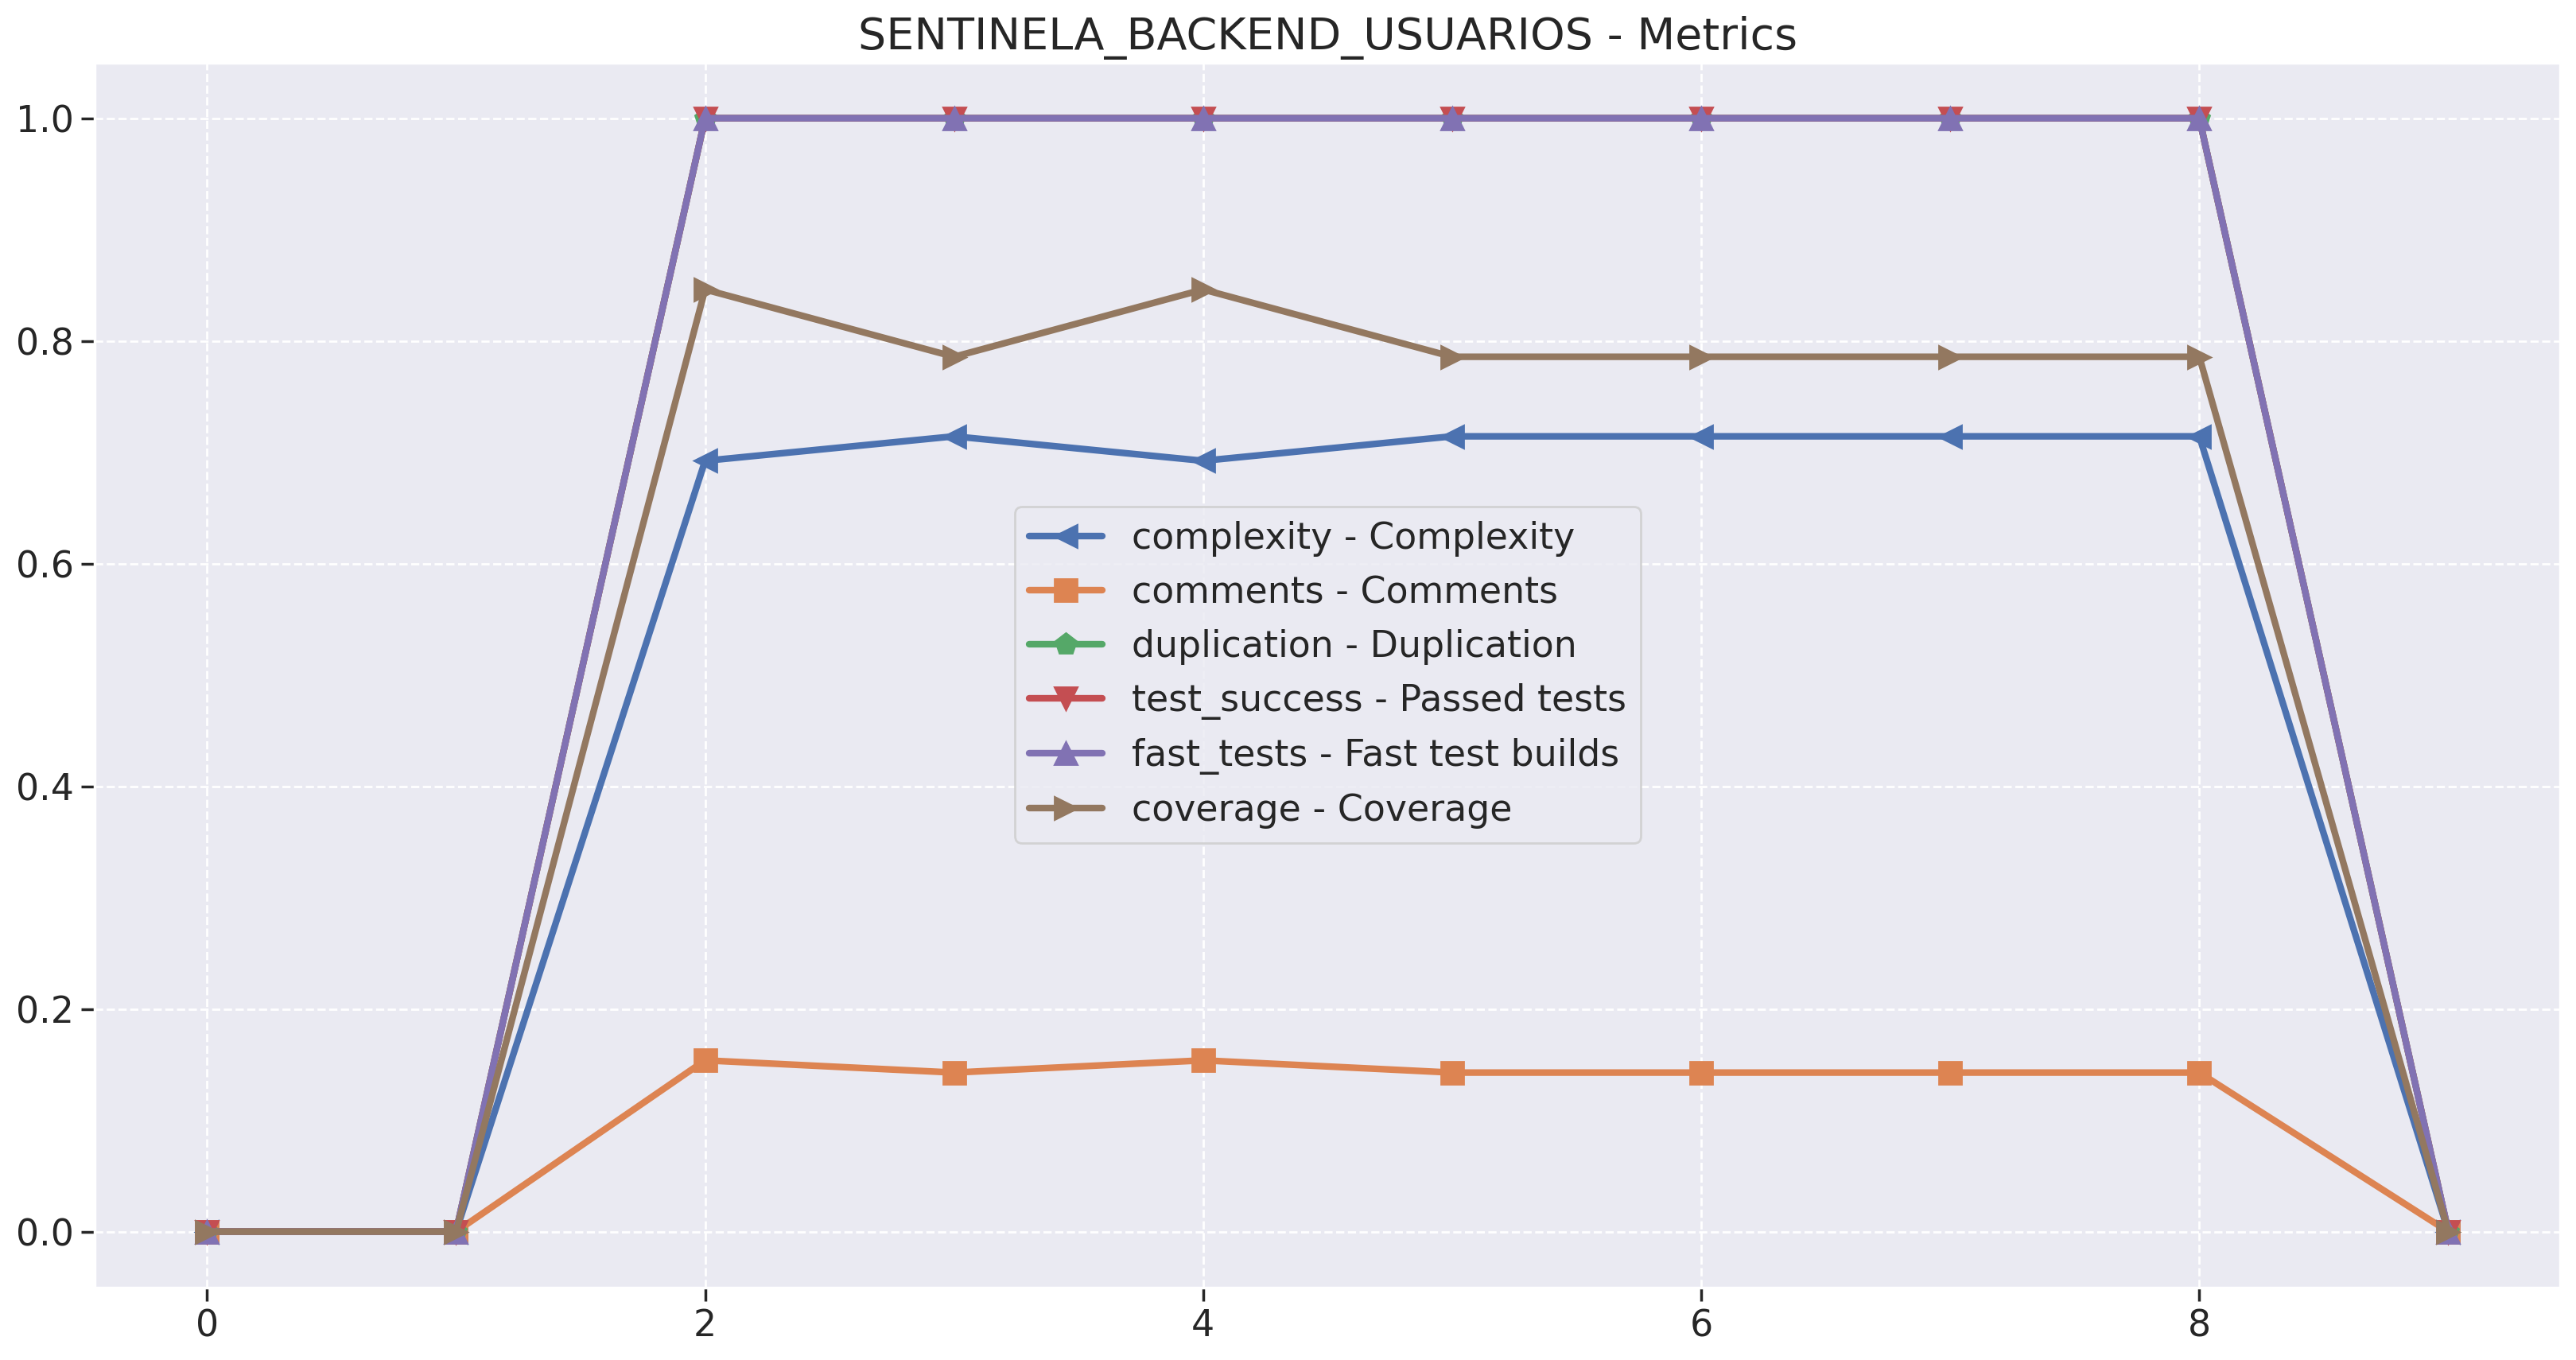

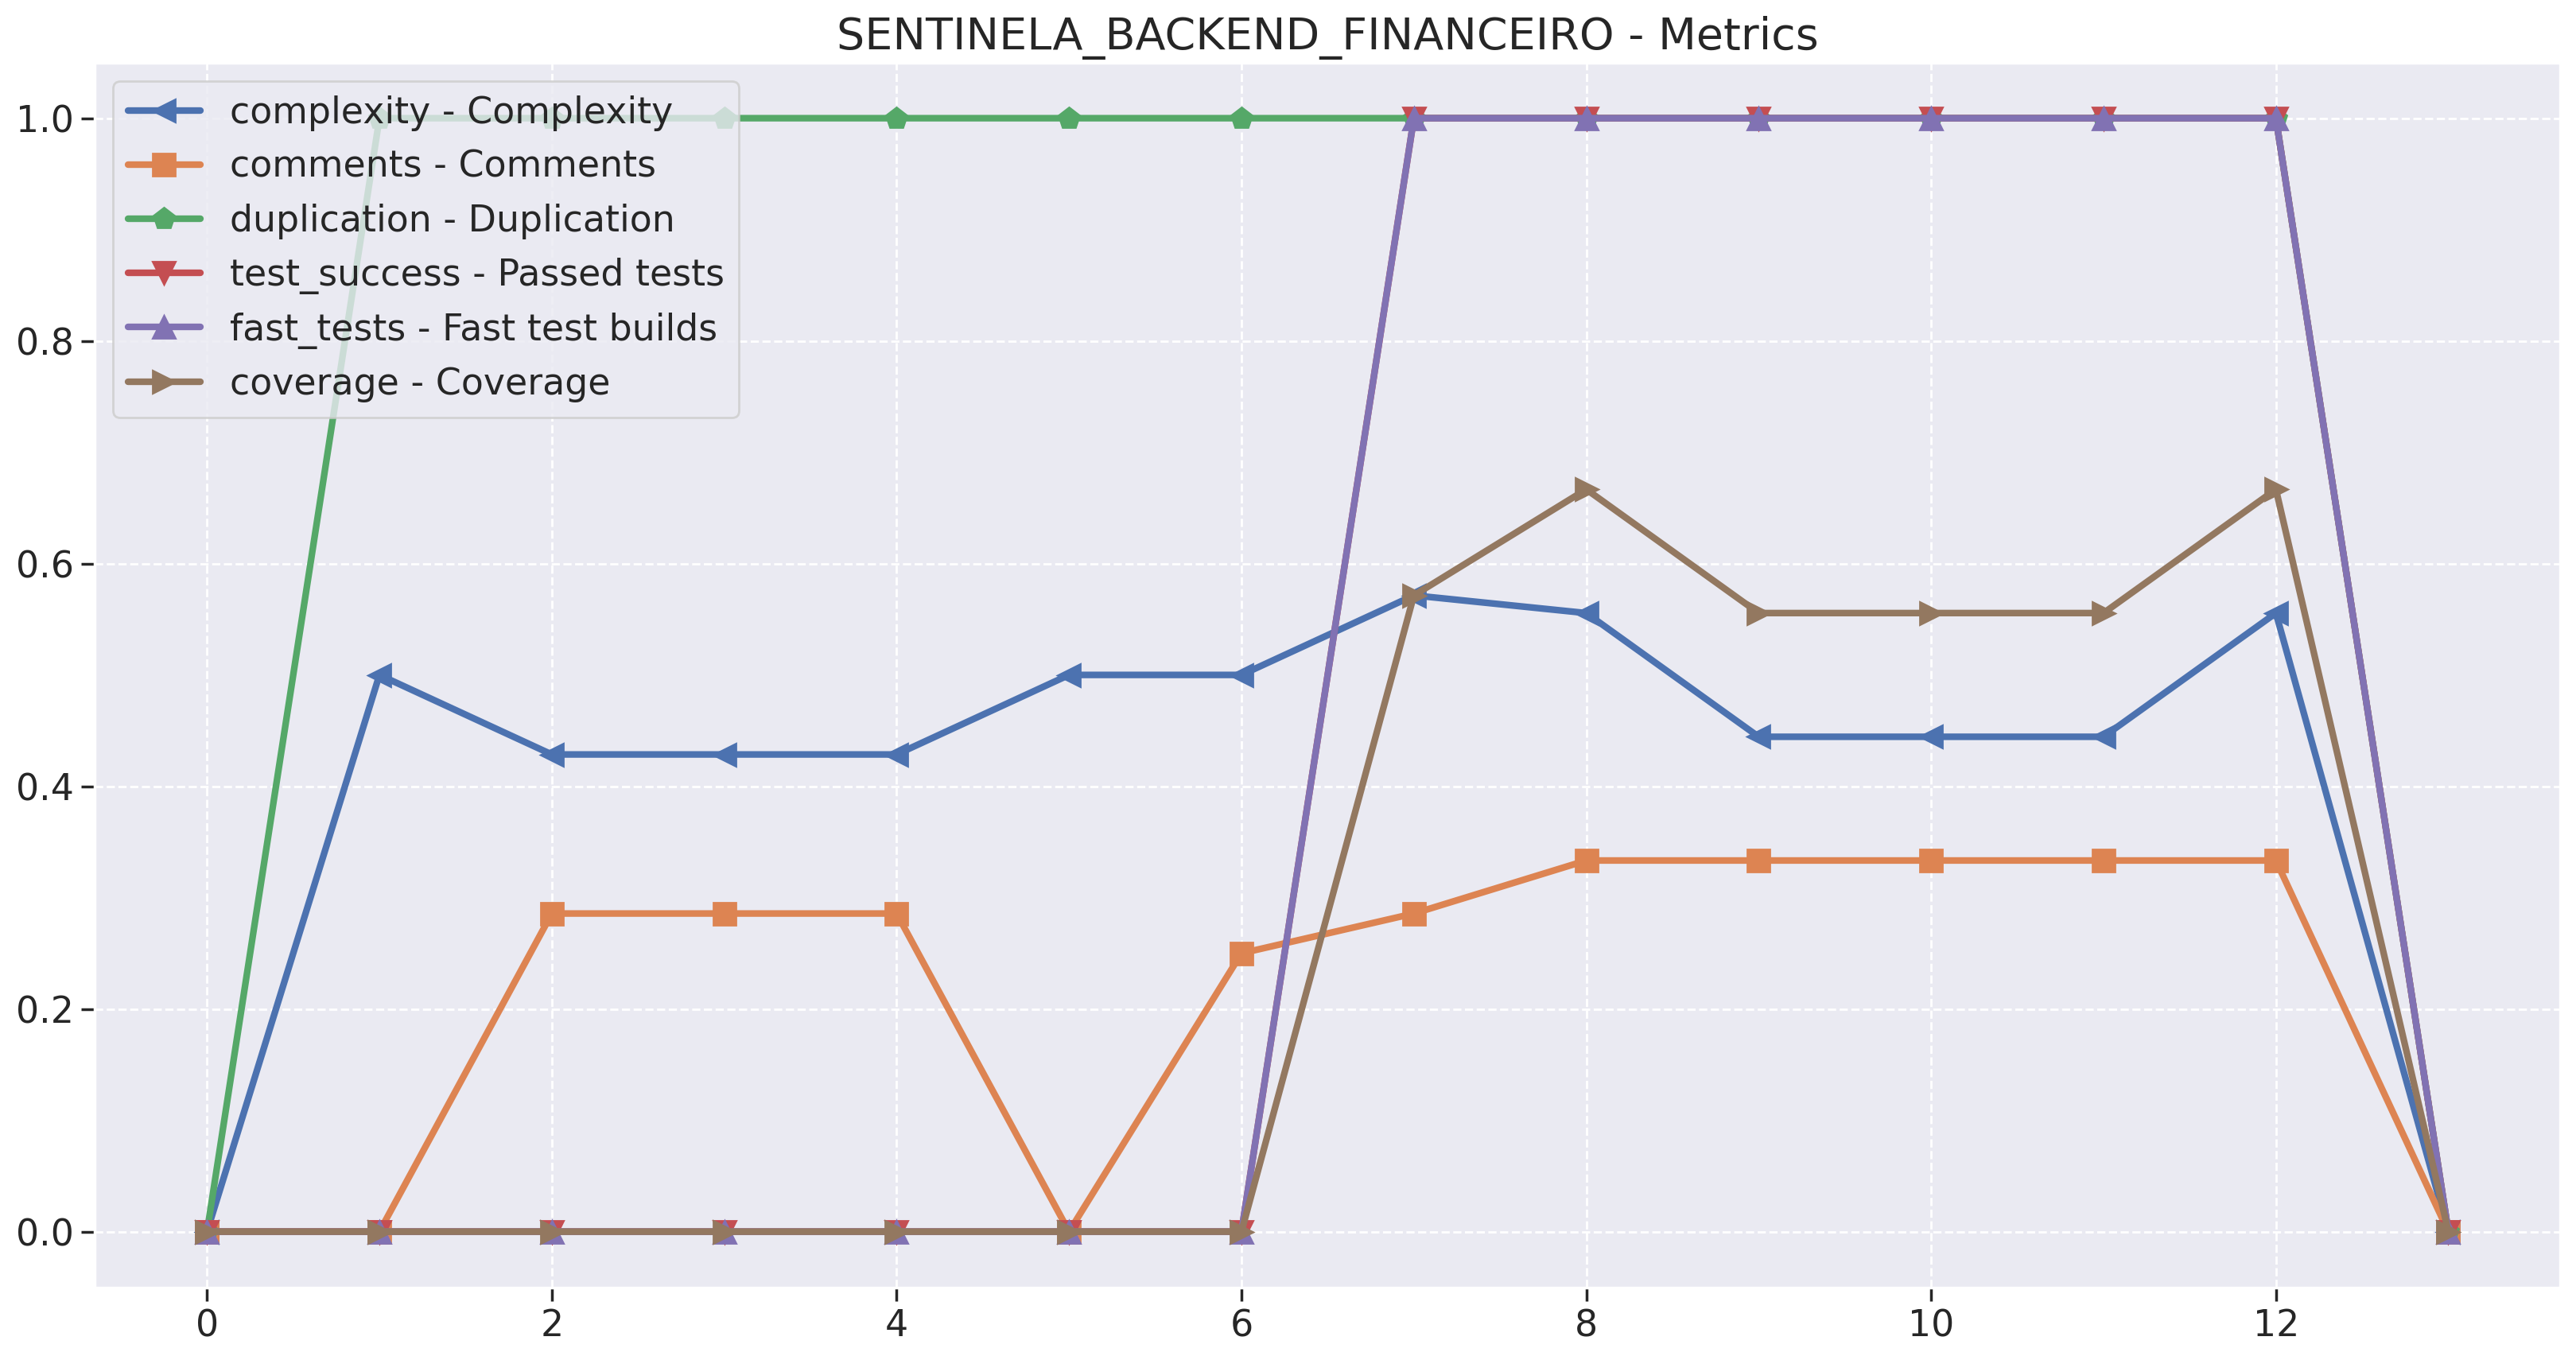

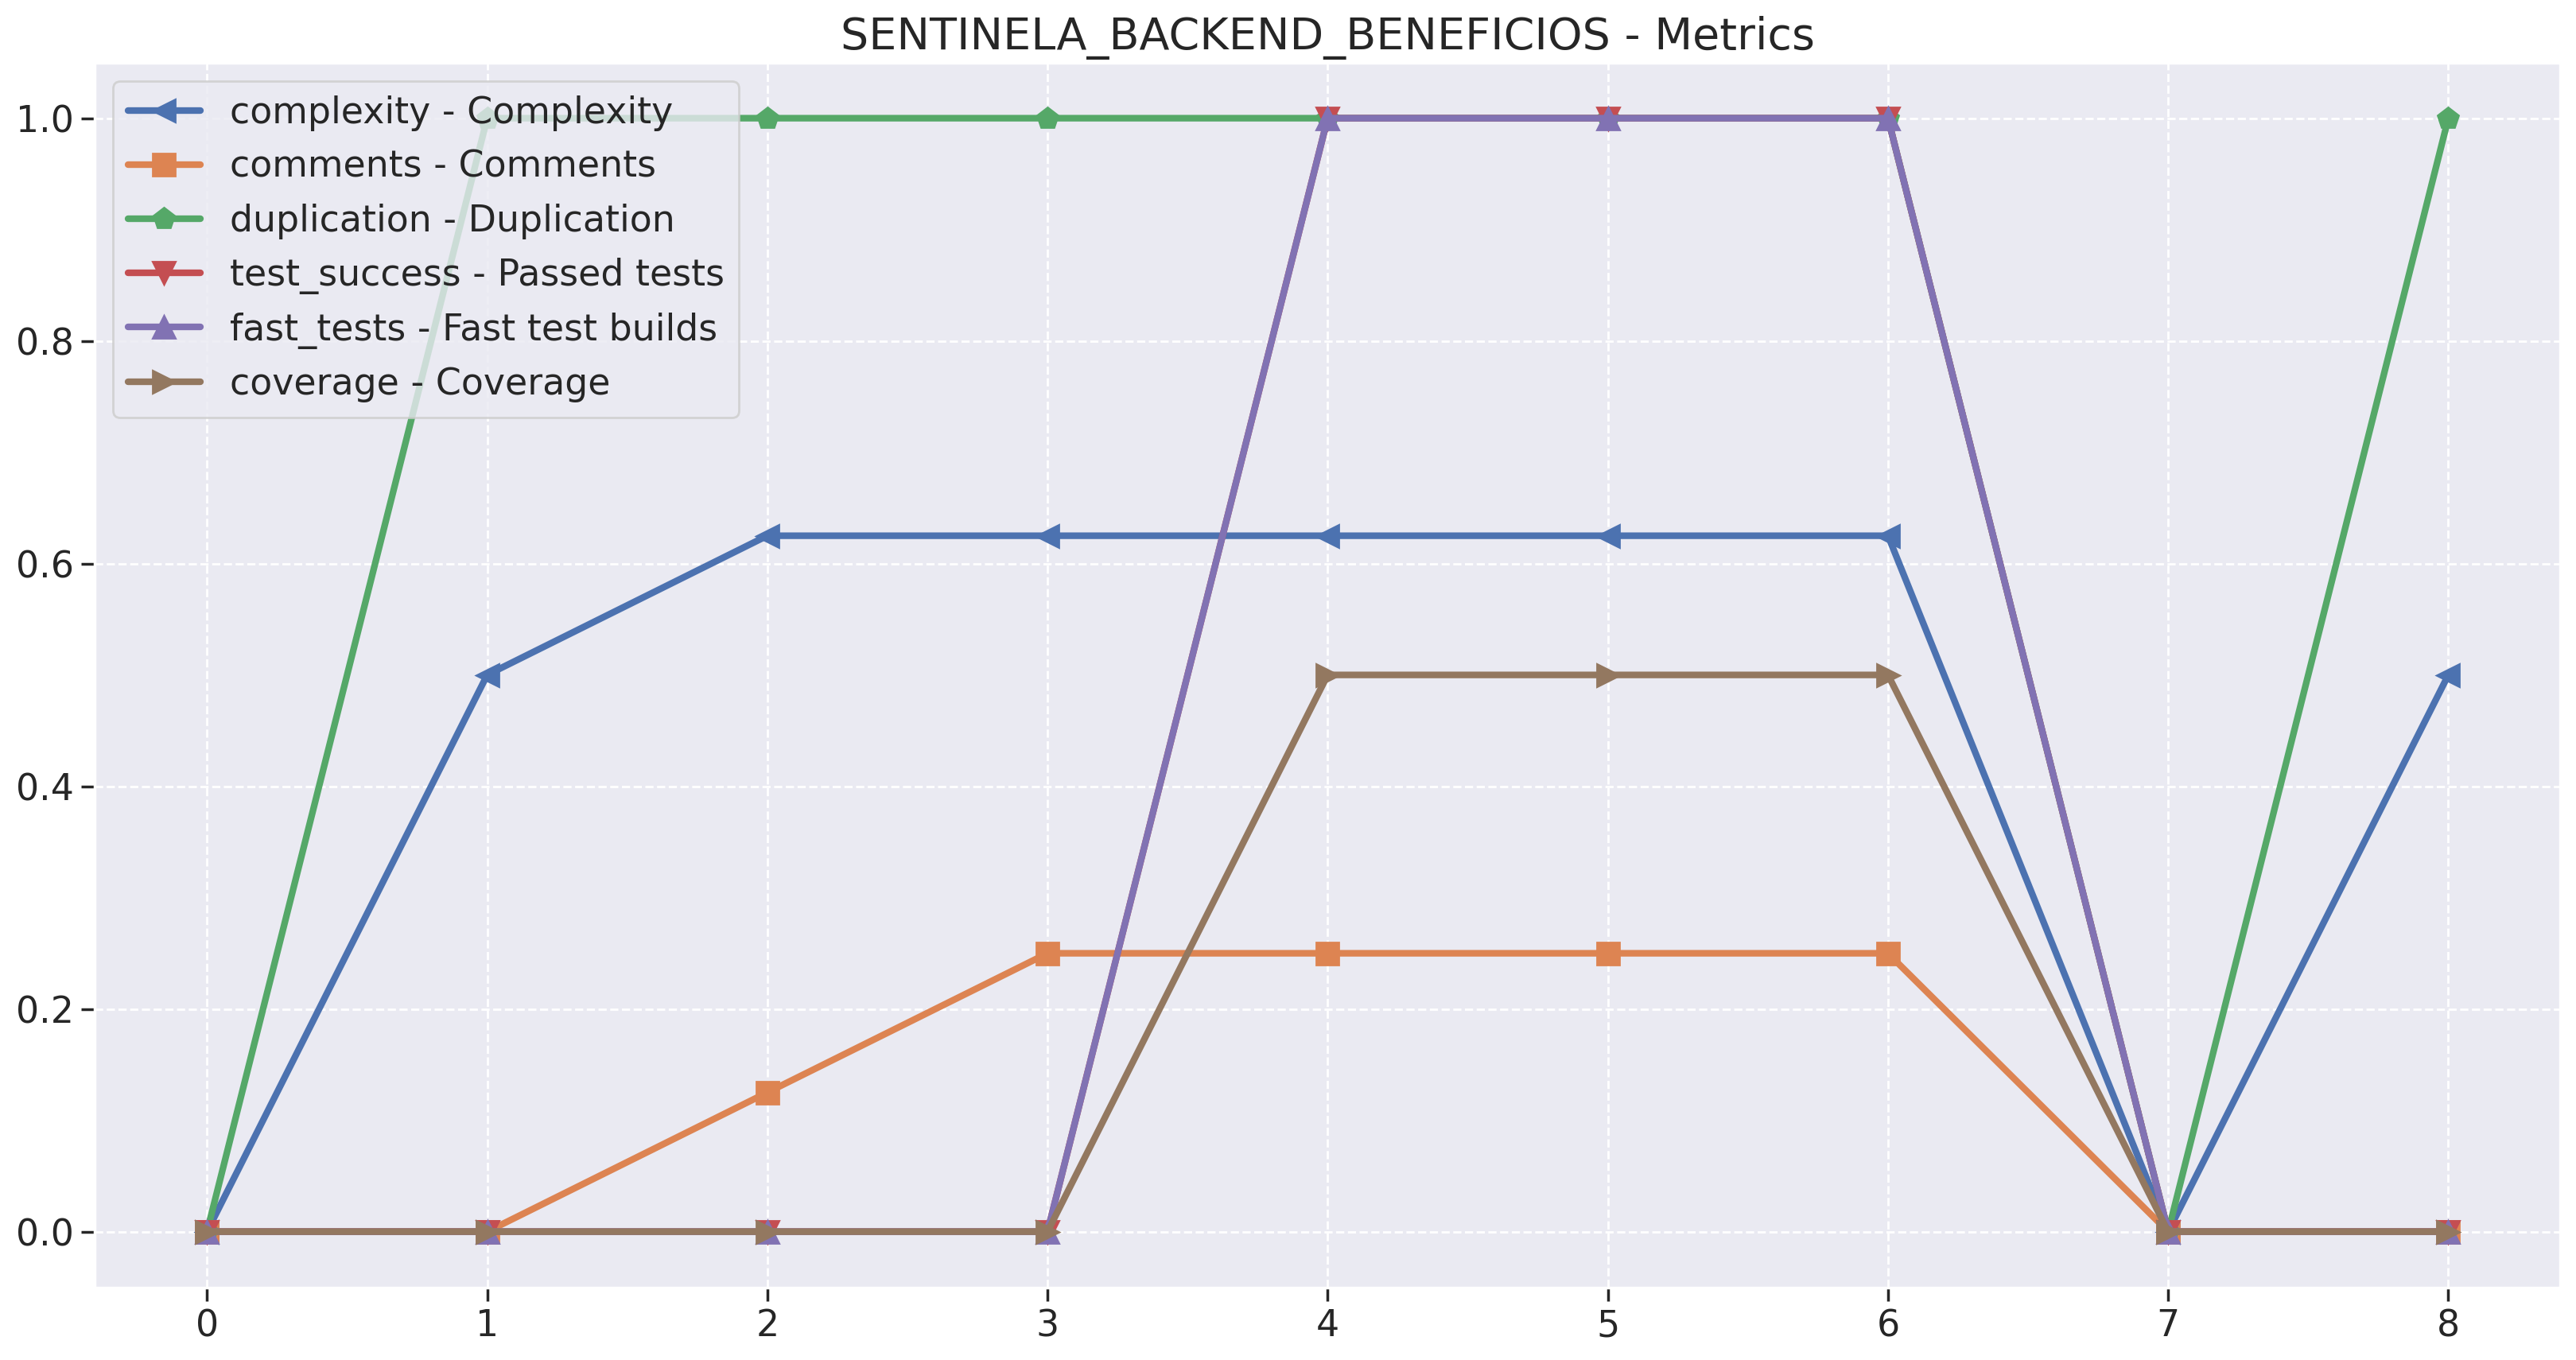

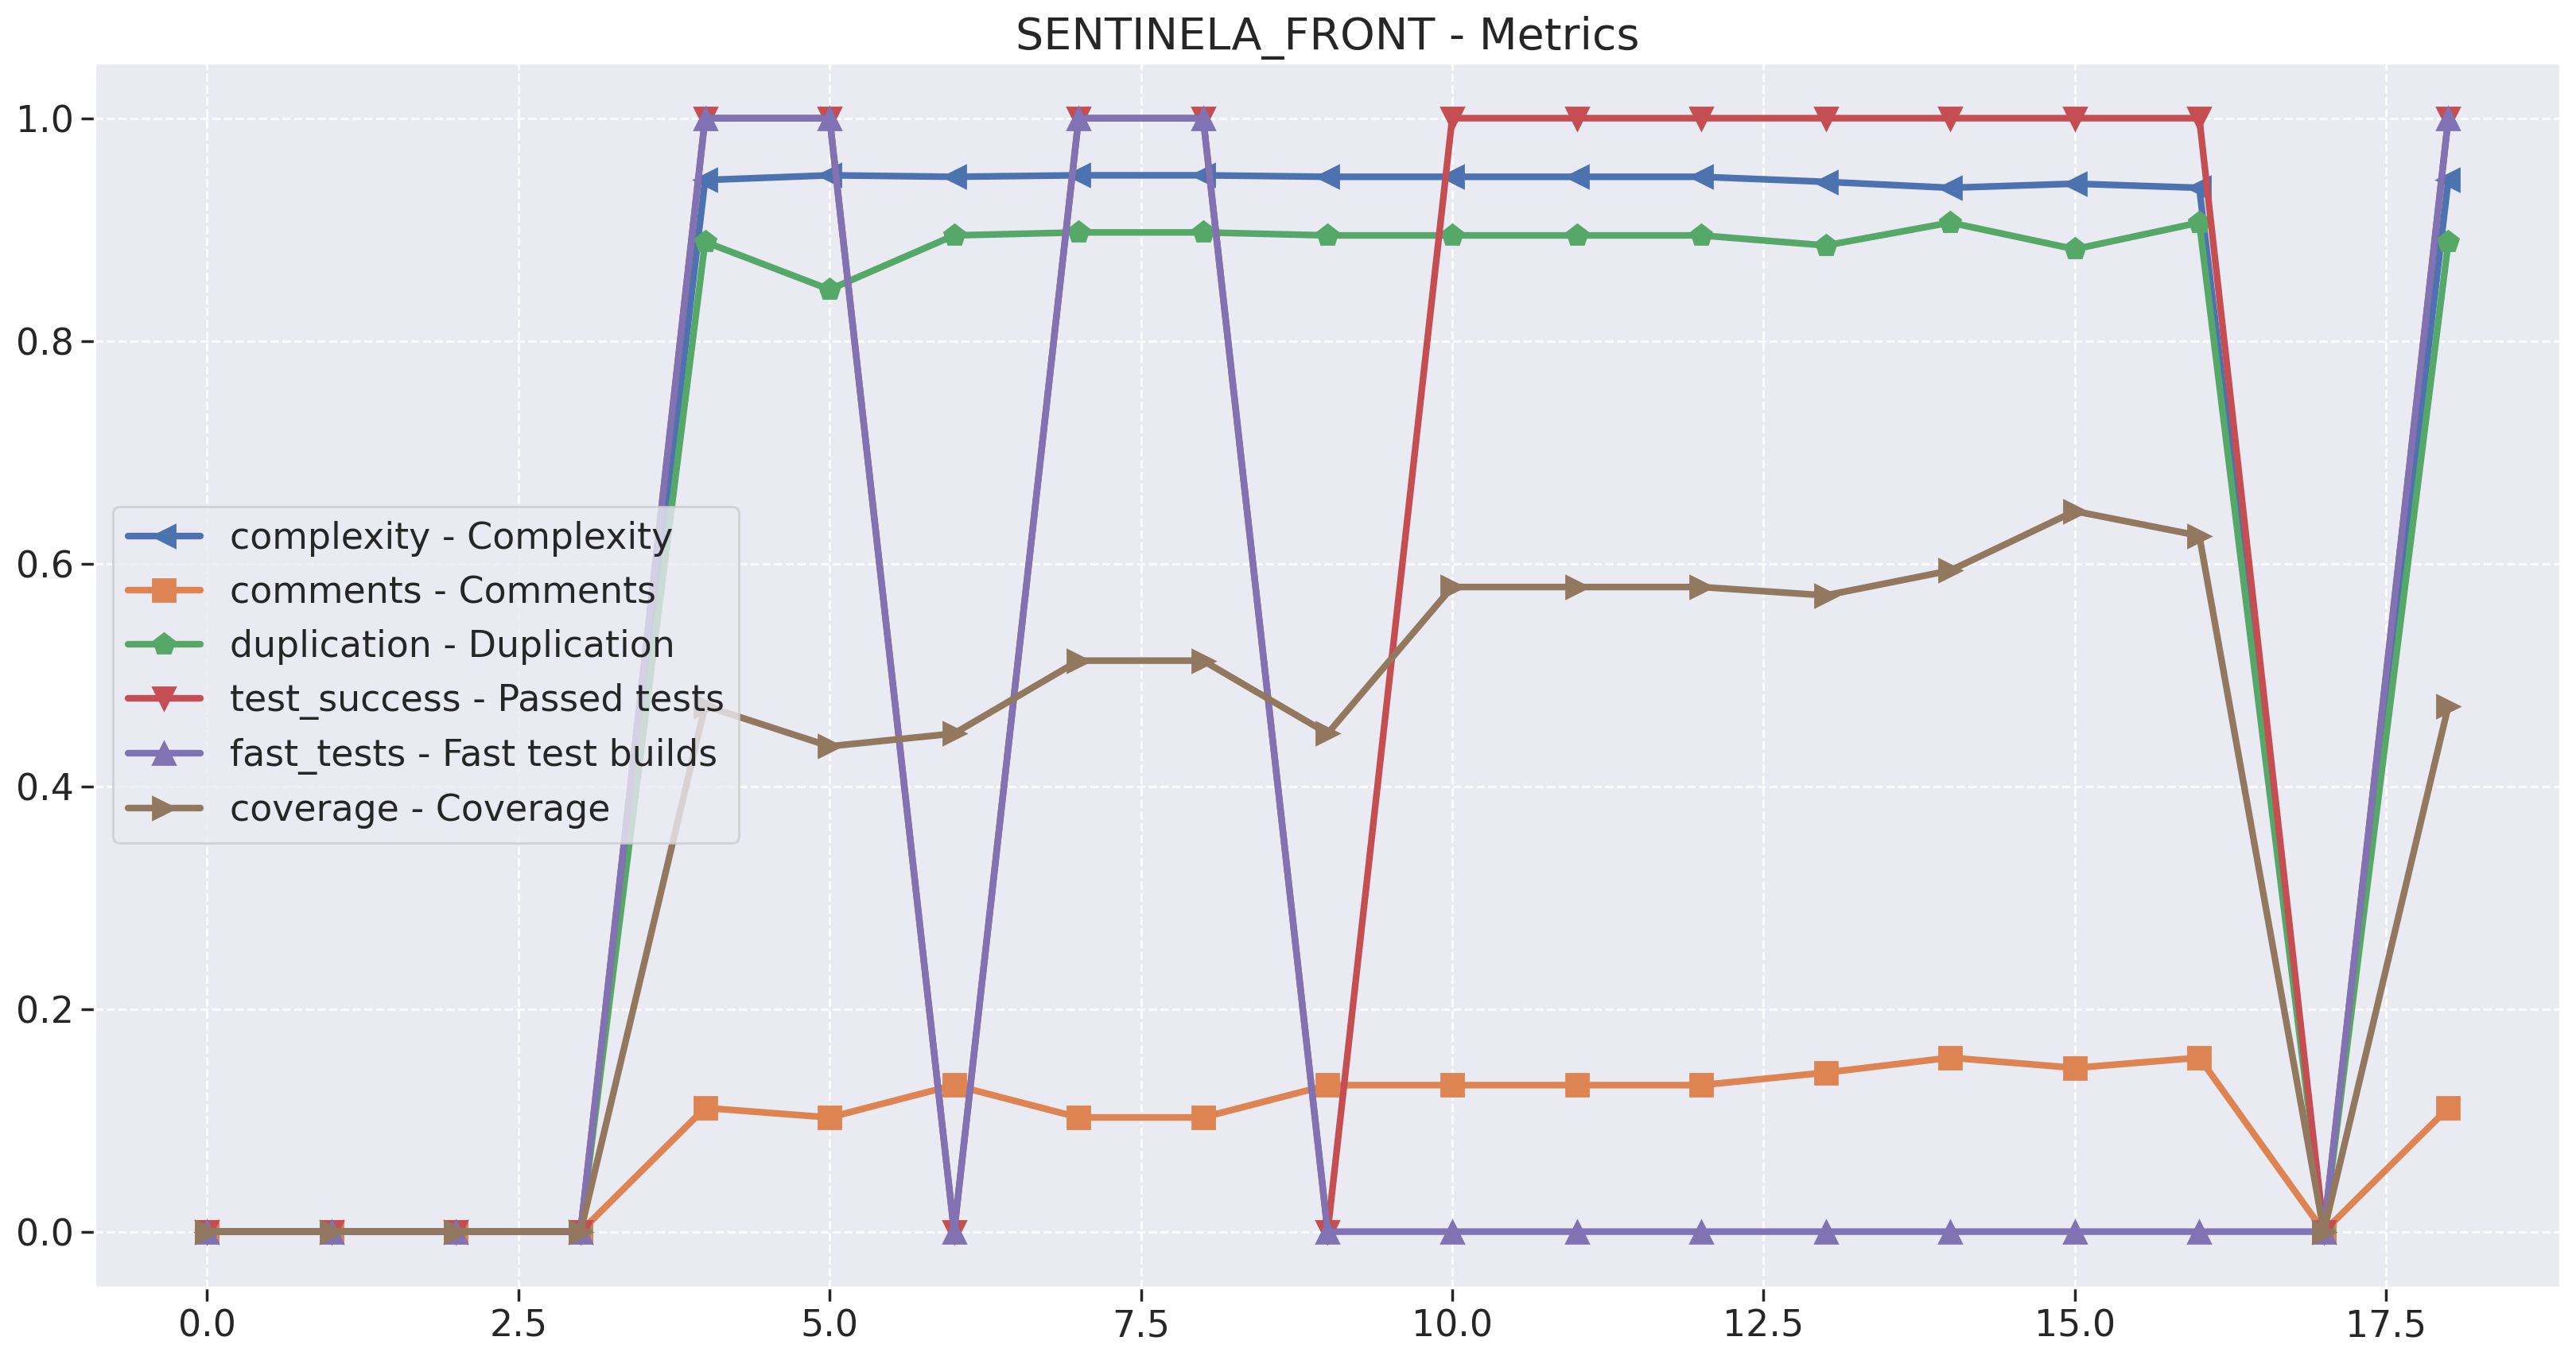

In [91]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['complexity'], linewidth=3, marker='<', markersize=10, label="complexity - Complexity")
    plt.plot(data['comments'], linewidth=3, marker='s', markersize=10, label="comments - Comments")
    plt.plot(data['duplication'], linewidth=3, marker='p', markersize=10, label="duplication - Duplication")
    plt.plot(data['test_success'], linewidth=3, marker='v', markersize=10, label="test_success - Passed tests")
    plt.plot(data['fast_tests'], linewidth=3, marker='^', markersize=10, label="fast_tests - Fast test builds")
    plt.plot(data['coverage'], linewidth=3, marker='>', markersize=10, label="coverage - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [92]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['complexity']*pm1) + (data['comments']*pm2) + (data['duplication']*pm3)) * psc1
    data['testing_status'] = ((data['test_success']*pm4) + (data['fast_tests']*pm5) + (data['coverage']*pm6)) * psc2

### Code Quality visualization

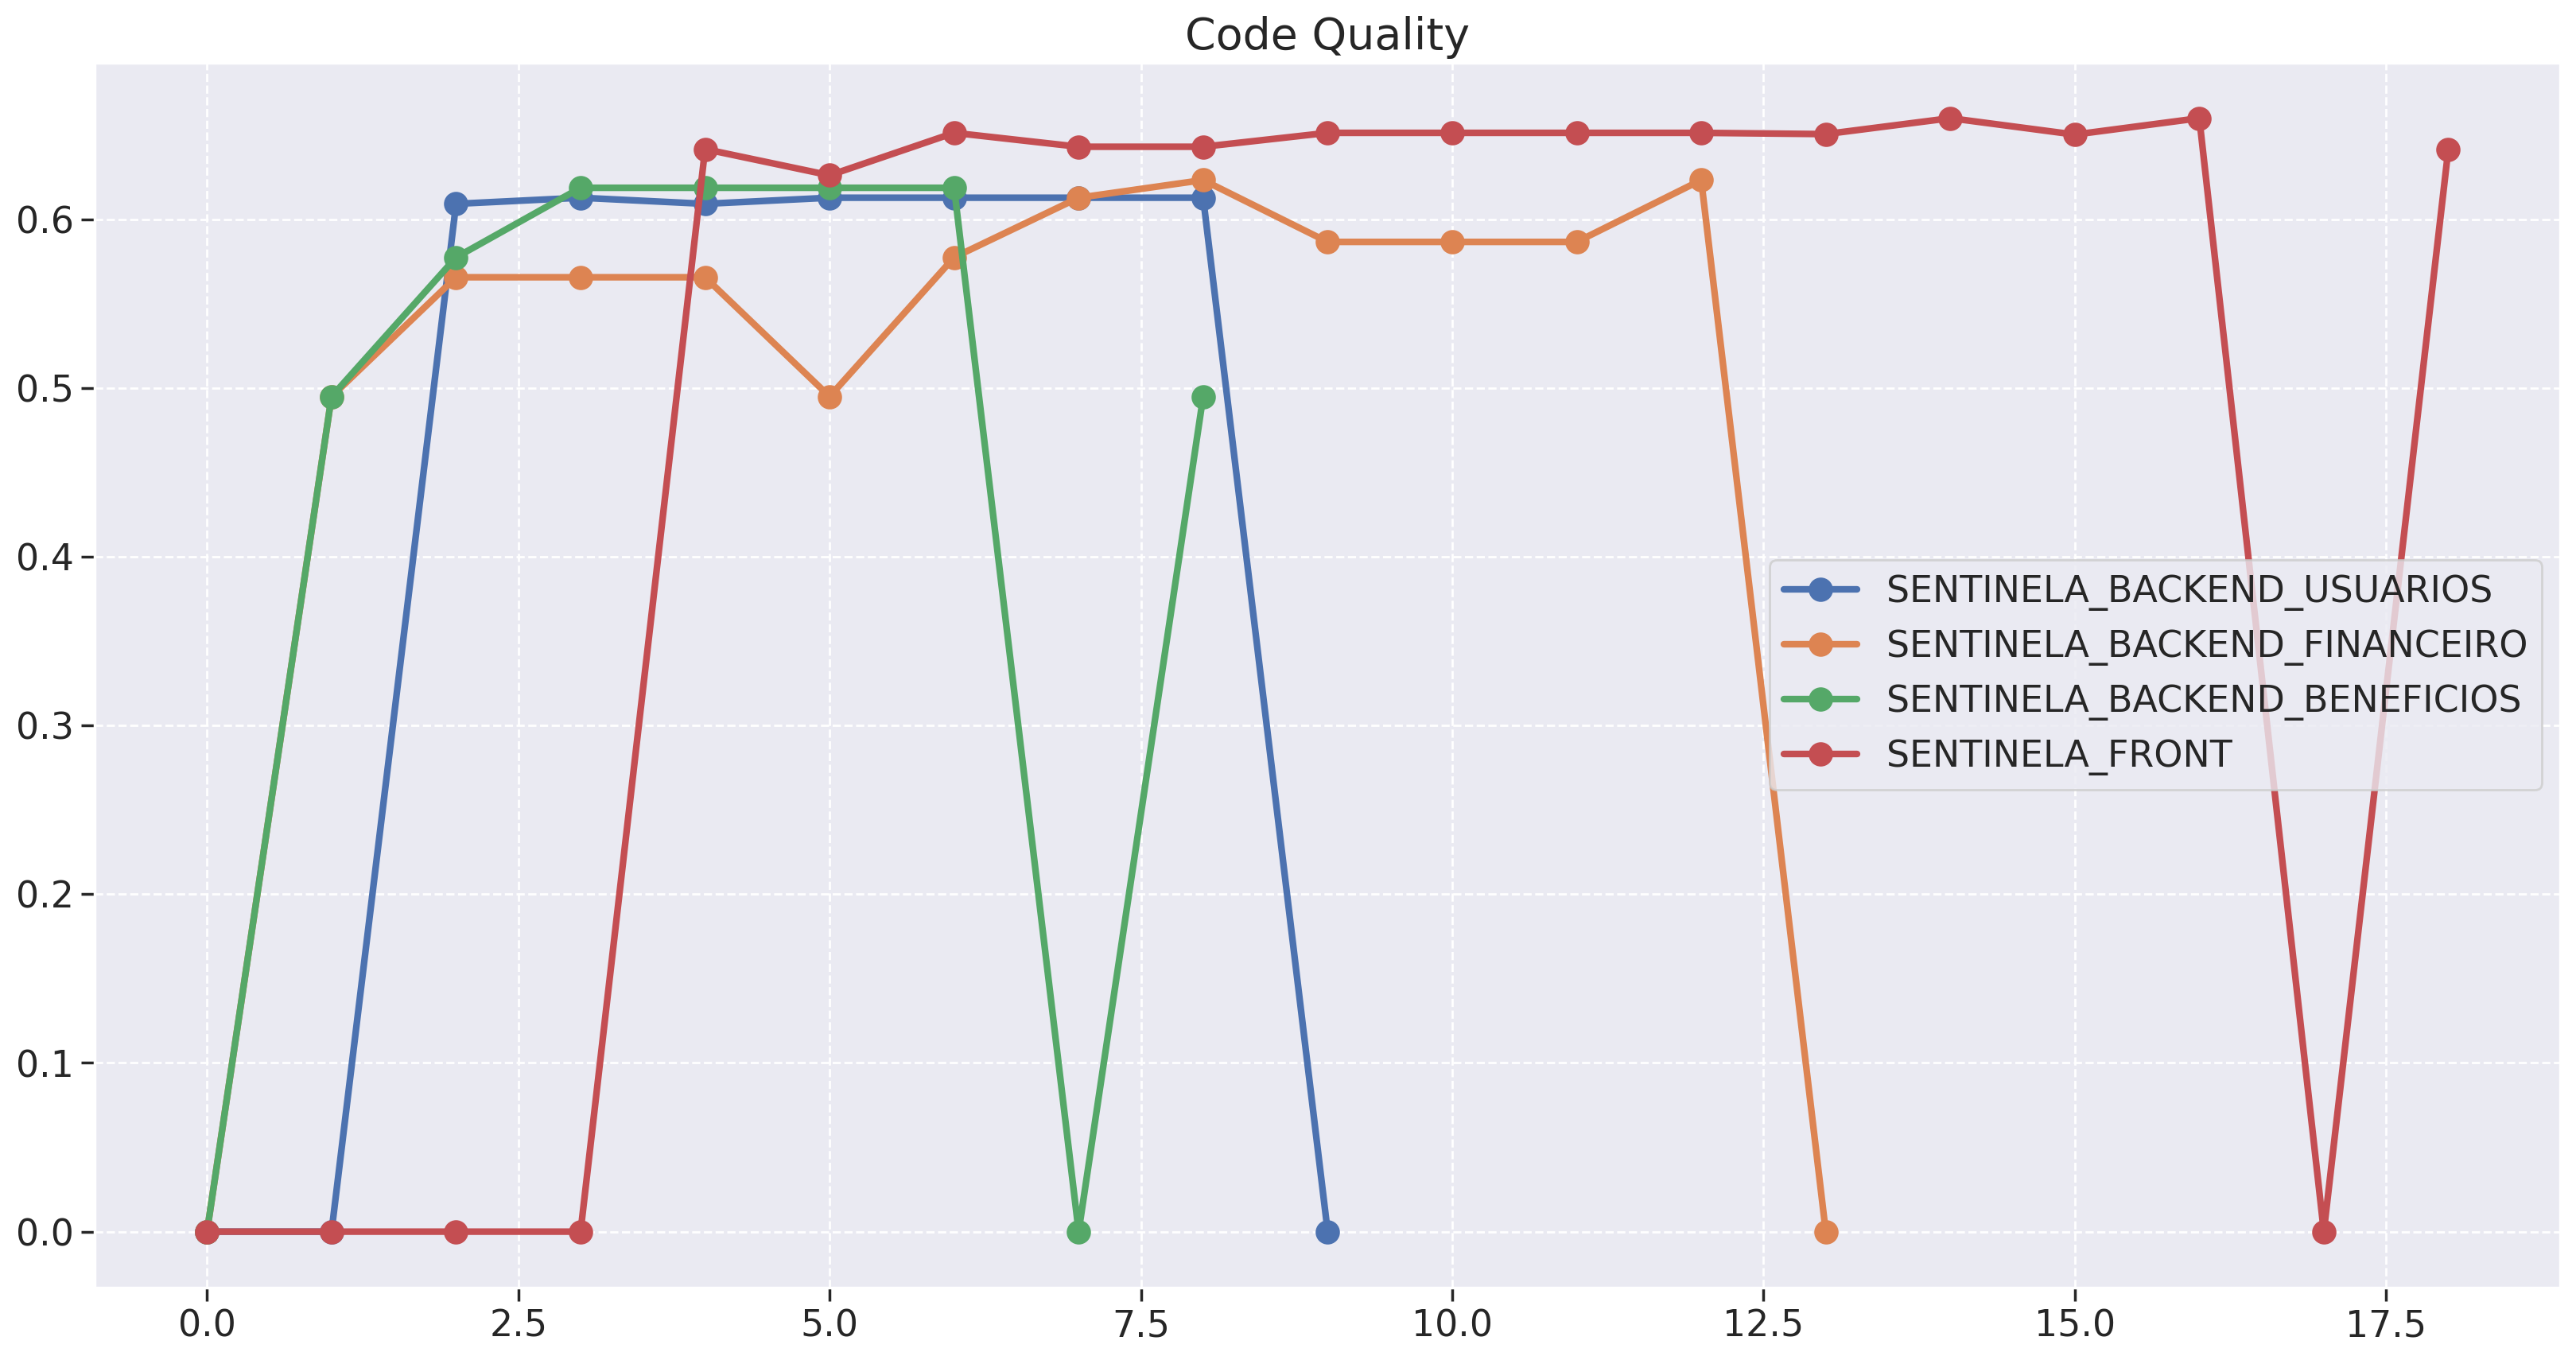

In [93]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

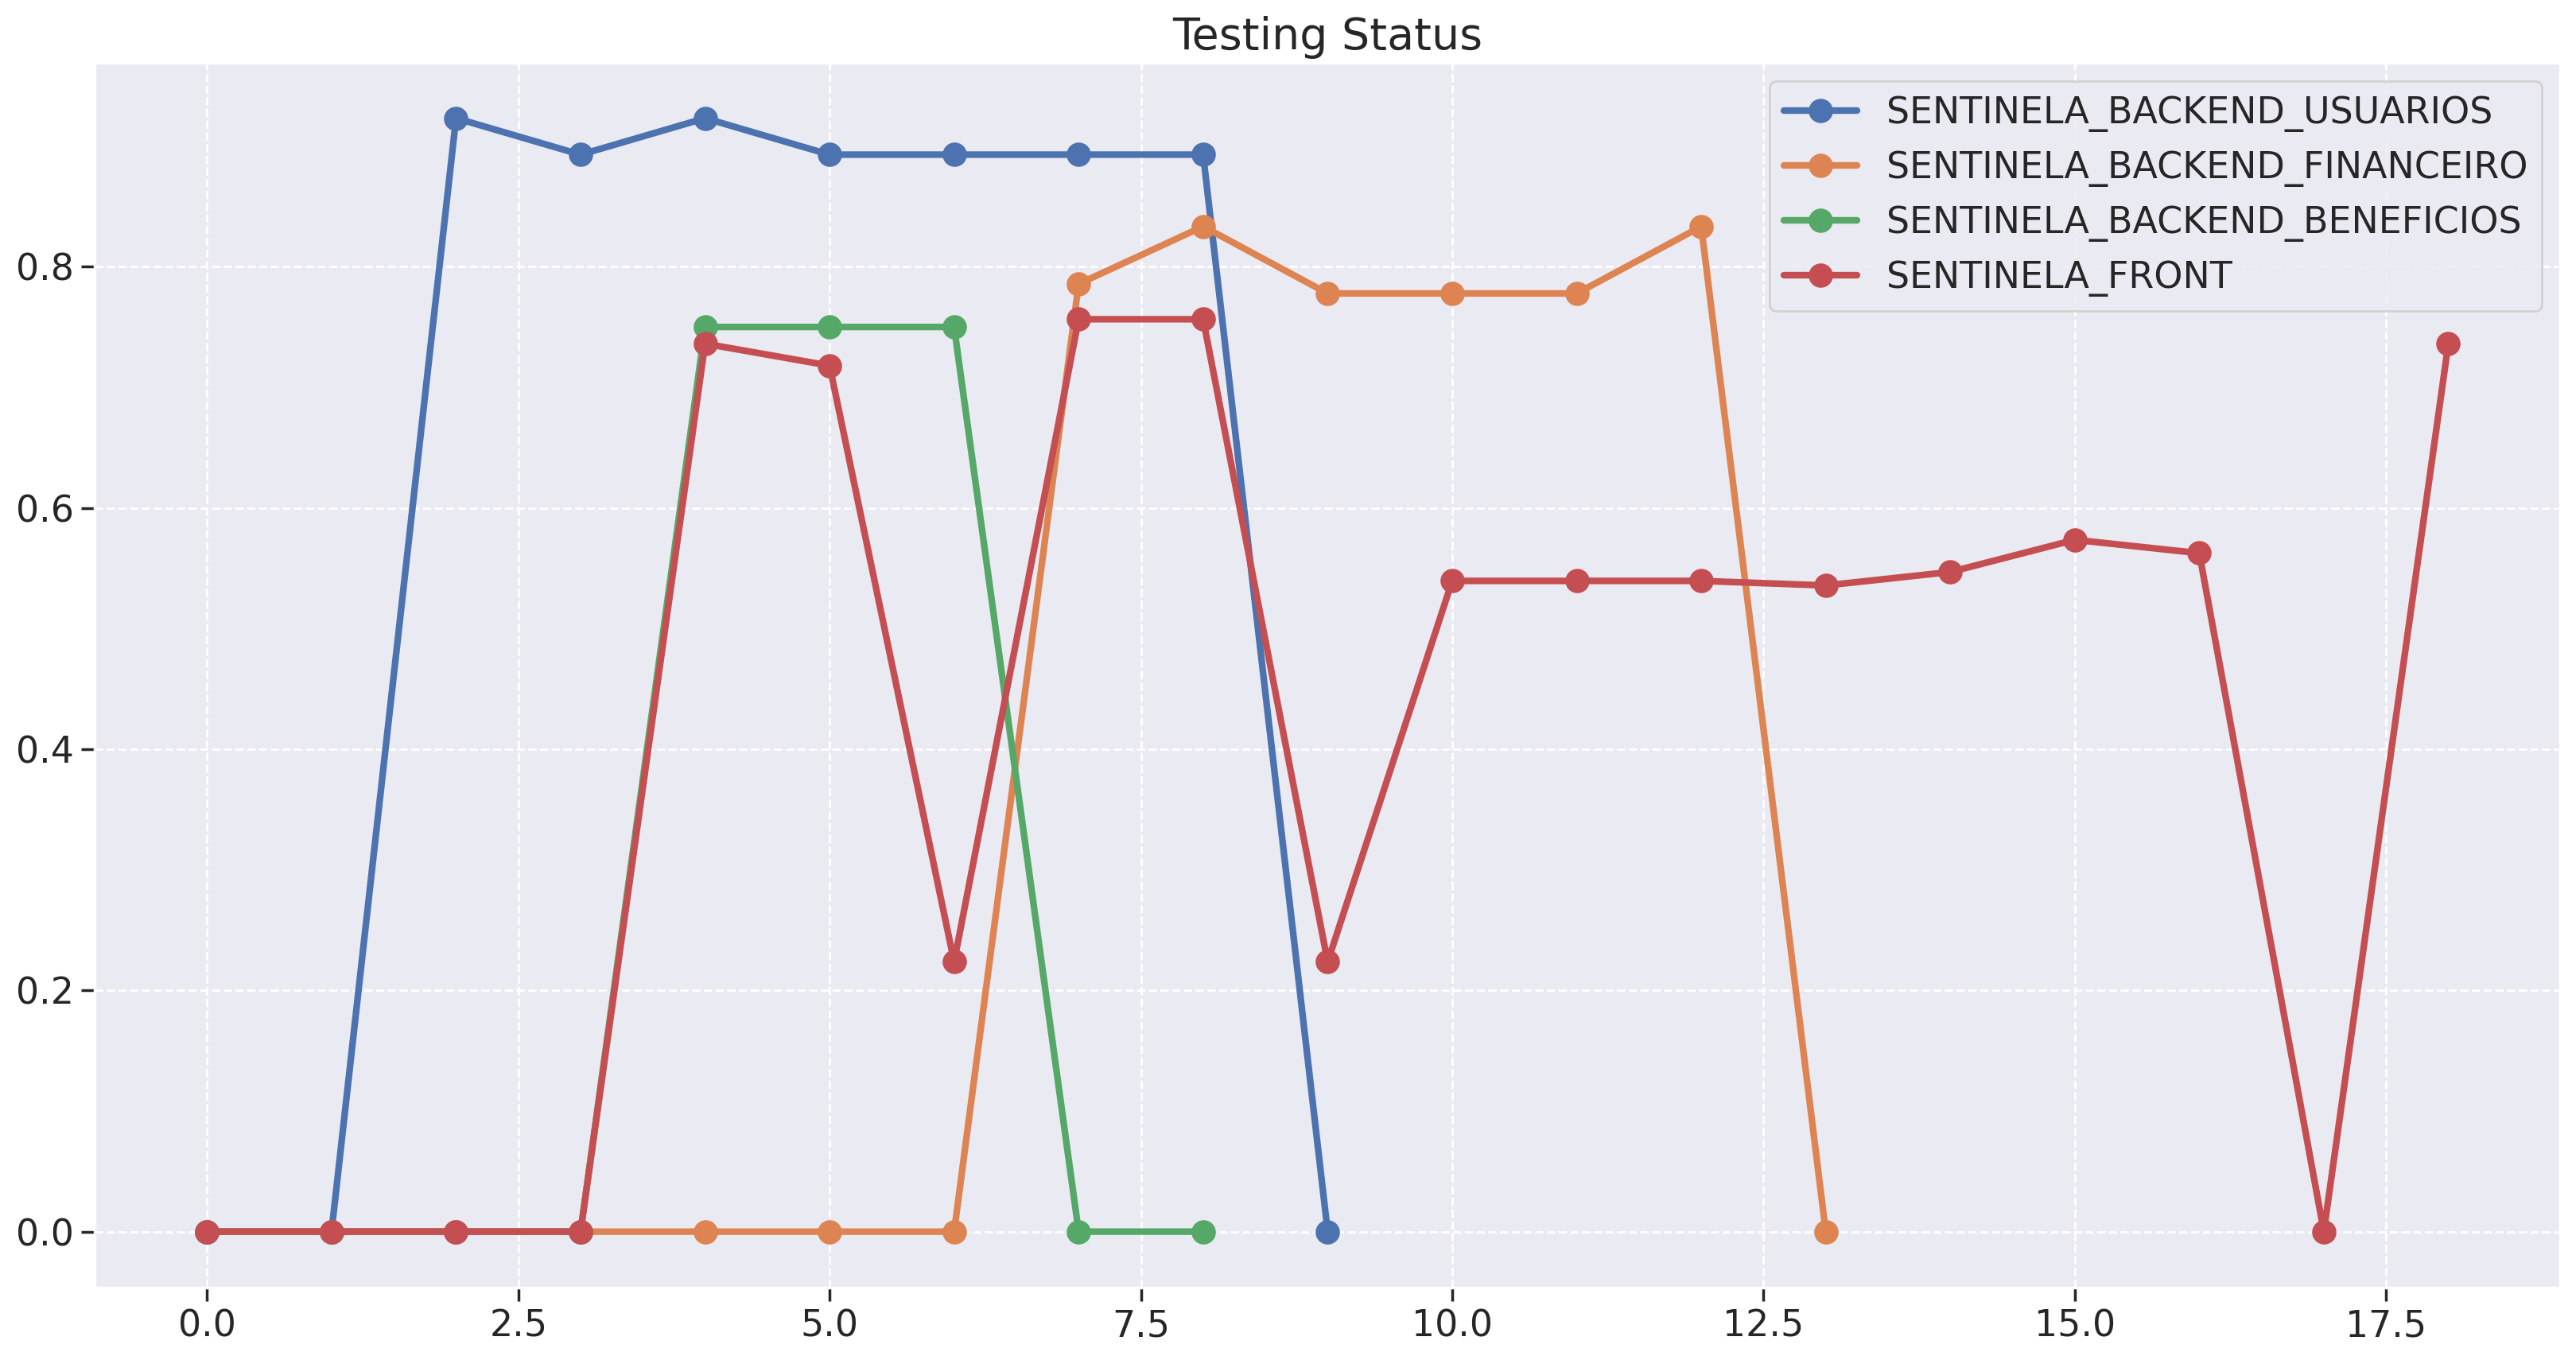

In [94]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [95]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [96]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [97]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

SENTINELA_BACKEND_USUARIOS
Maintainability Stats
    mean     mode   median      std      var  min      max
0.214137 0.306429 0.305522 0.147771 0.021836  0.0 0.306429
Reliability Stats
    mean     mode   median      std      var  min      max
0.315522 0.446429 0.446429 0.217814 0.047443  0.0 0.461538


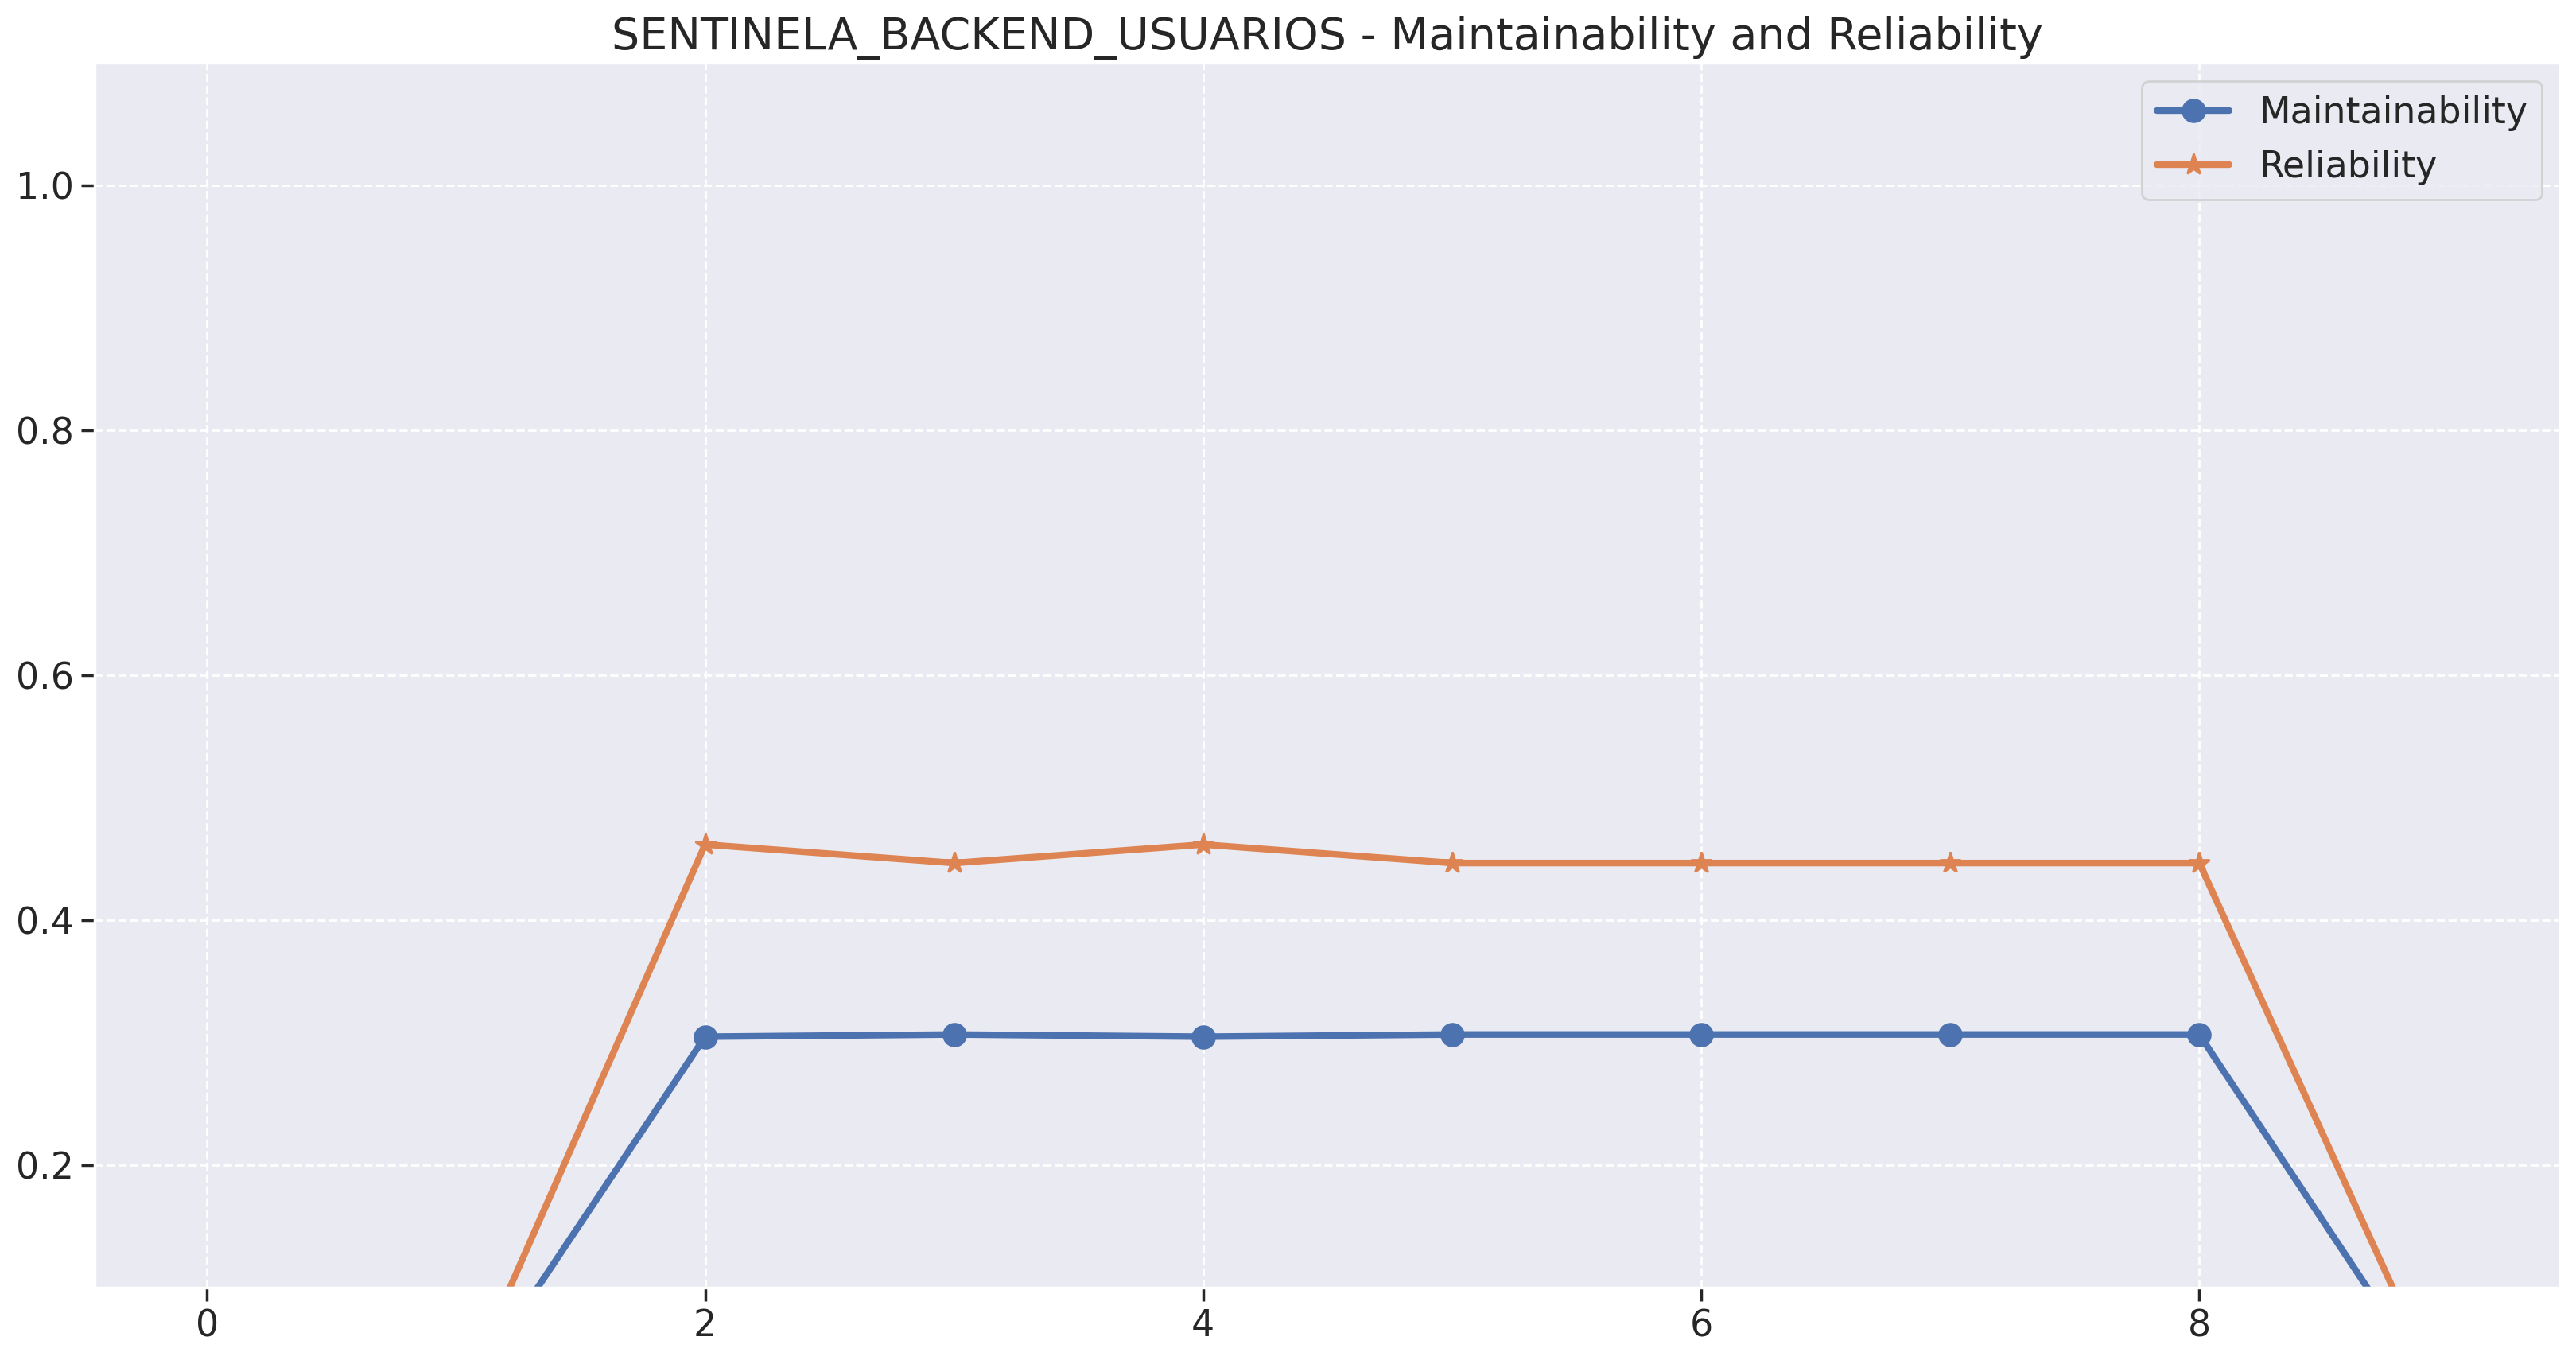

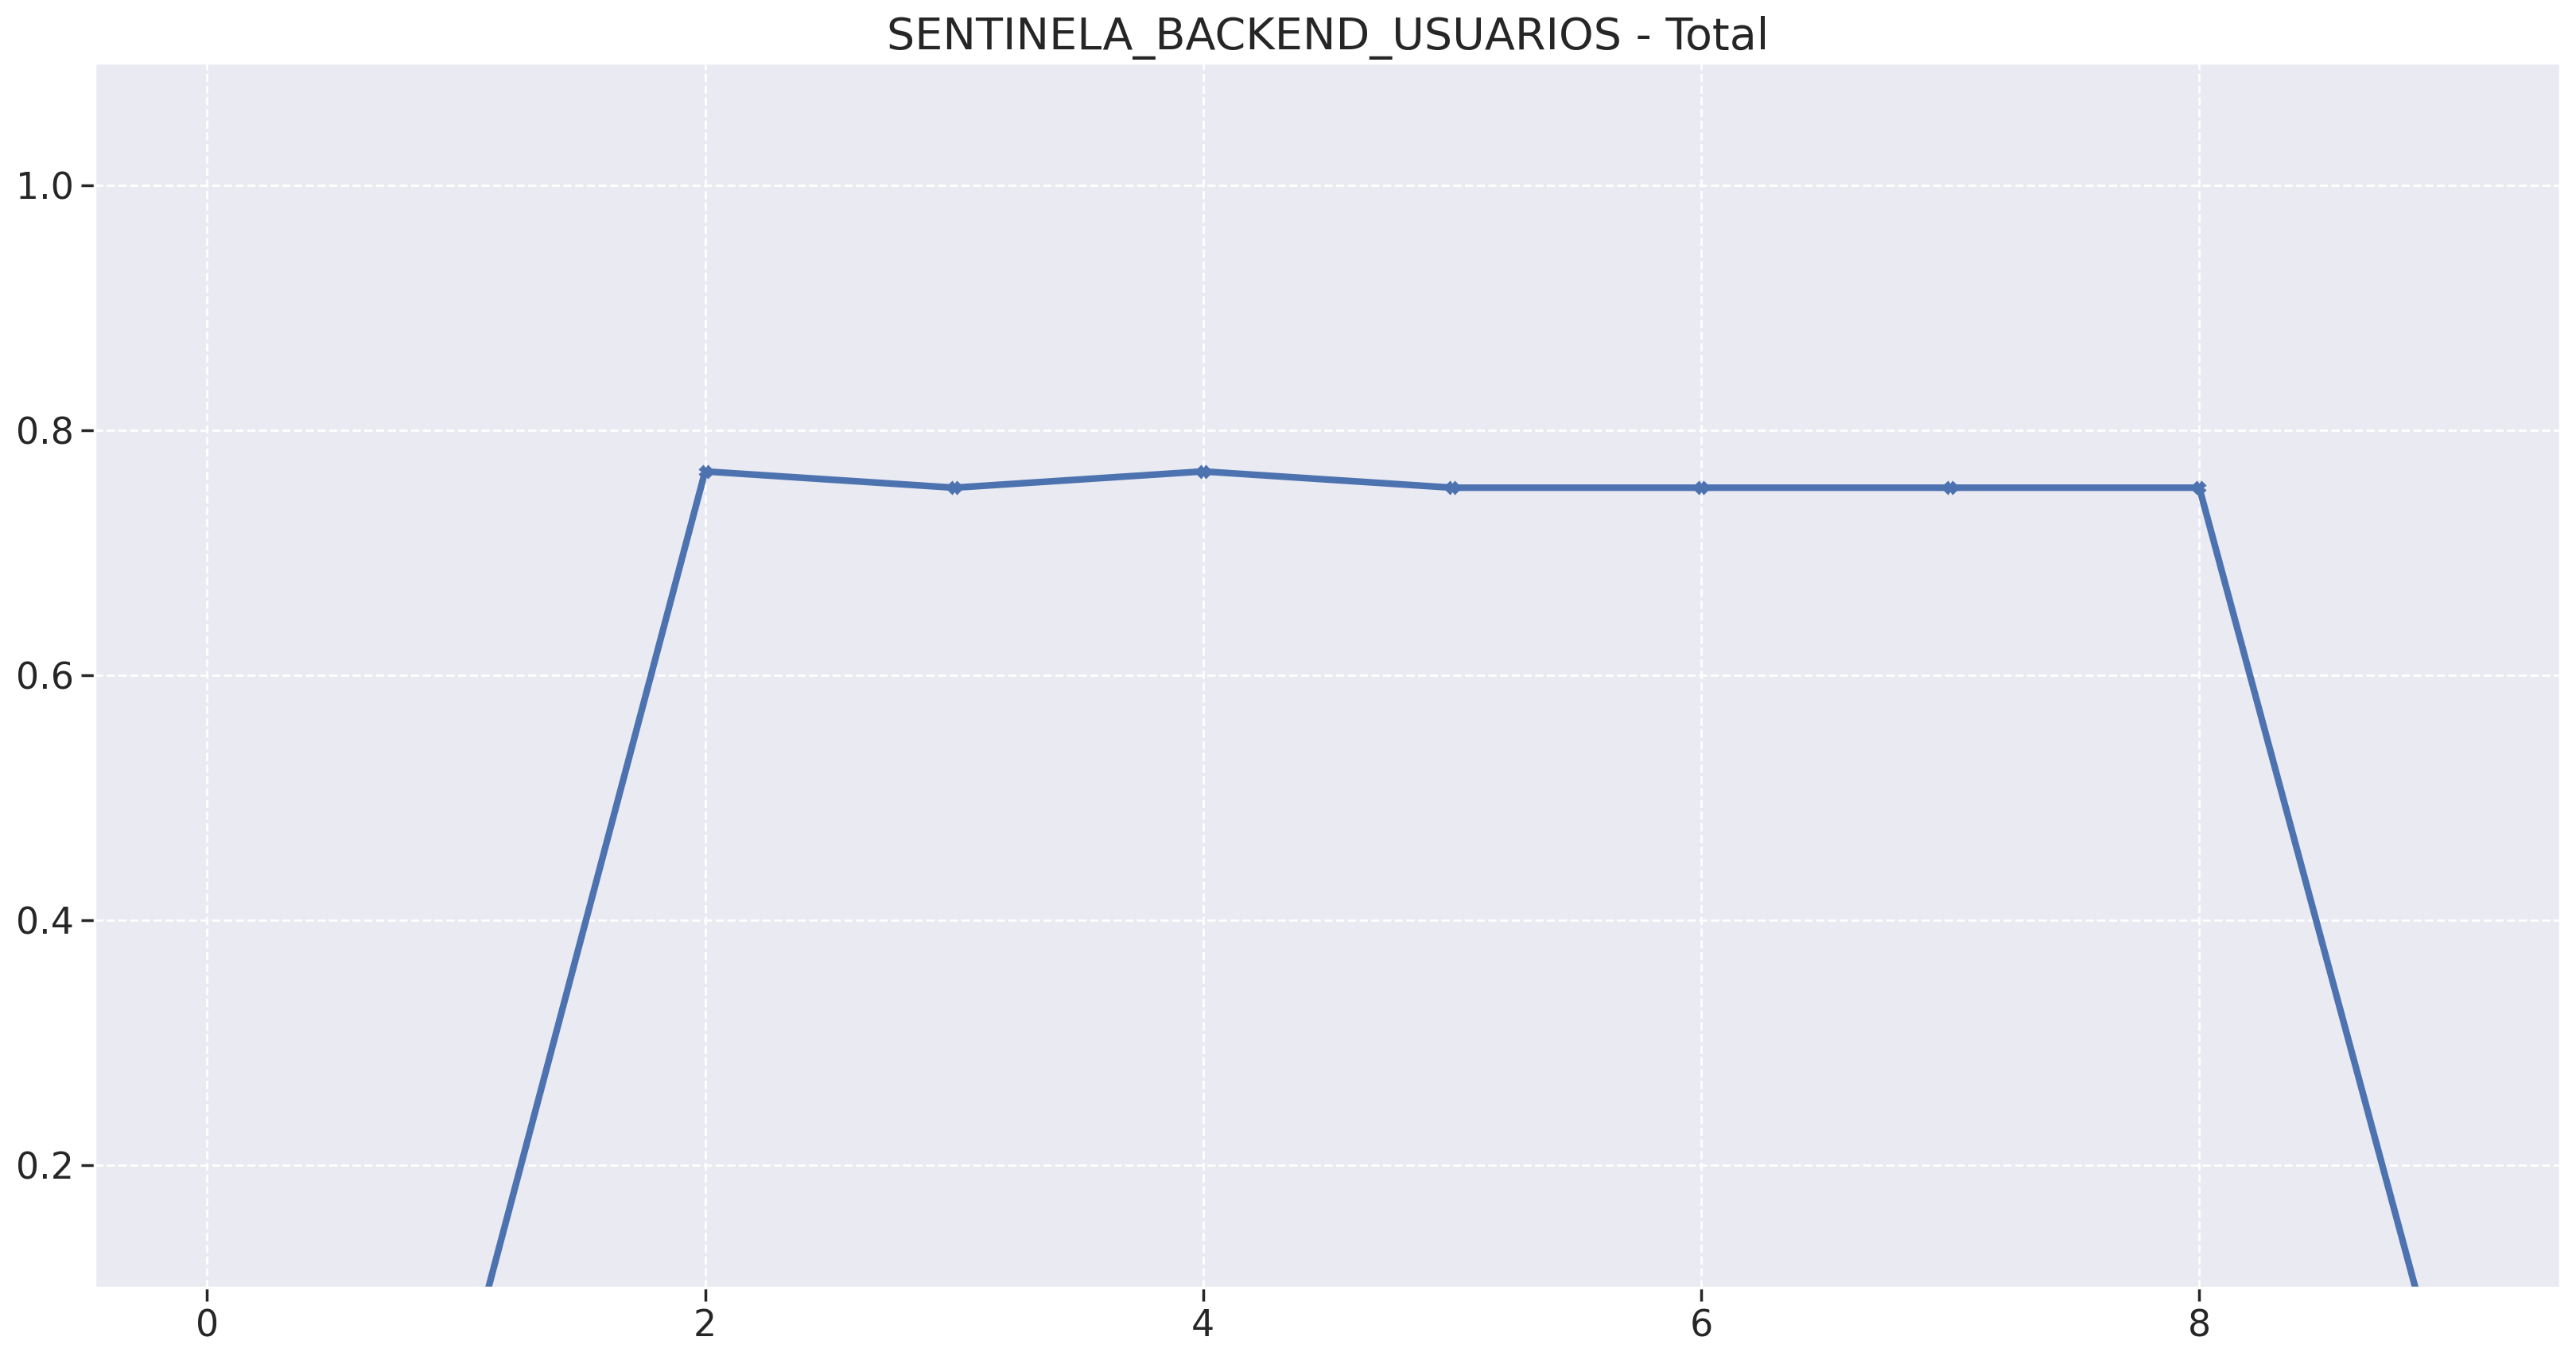

SENTINELA_BACKEND_FINANCEIRO
Maintainability Stats
    mean     mode   median      std      var  min      max
0.245863 0.282857 0.285804 0.105952 0.011226  0.0 0.311667
0.245863 0.293333 0.285804 0.105952 0.011226  0.0 0.311667
Reliability Stats
    mean  mode  median      std      var  min      max
0.170918   0.0     0.0 0.204991 0.042021  0.0 0.416667


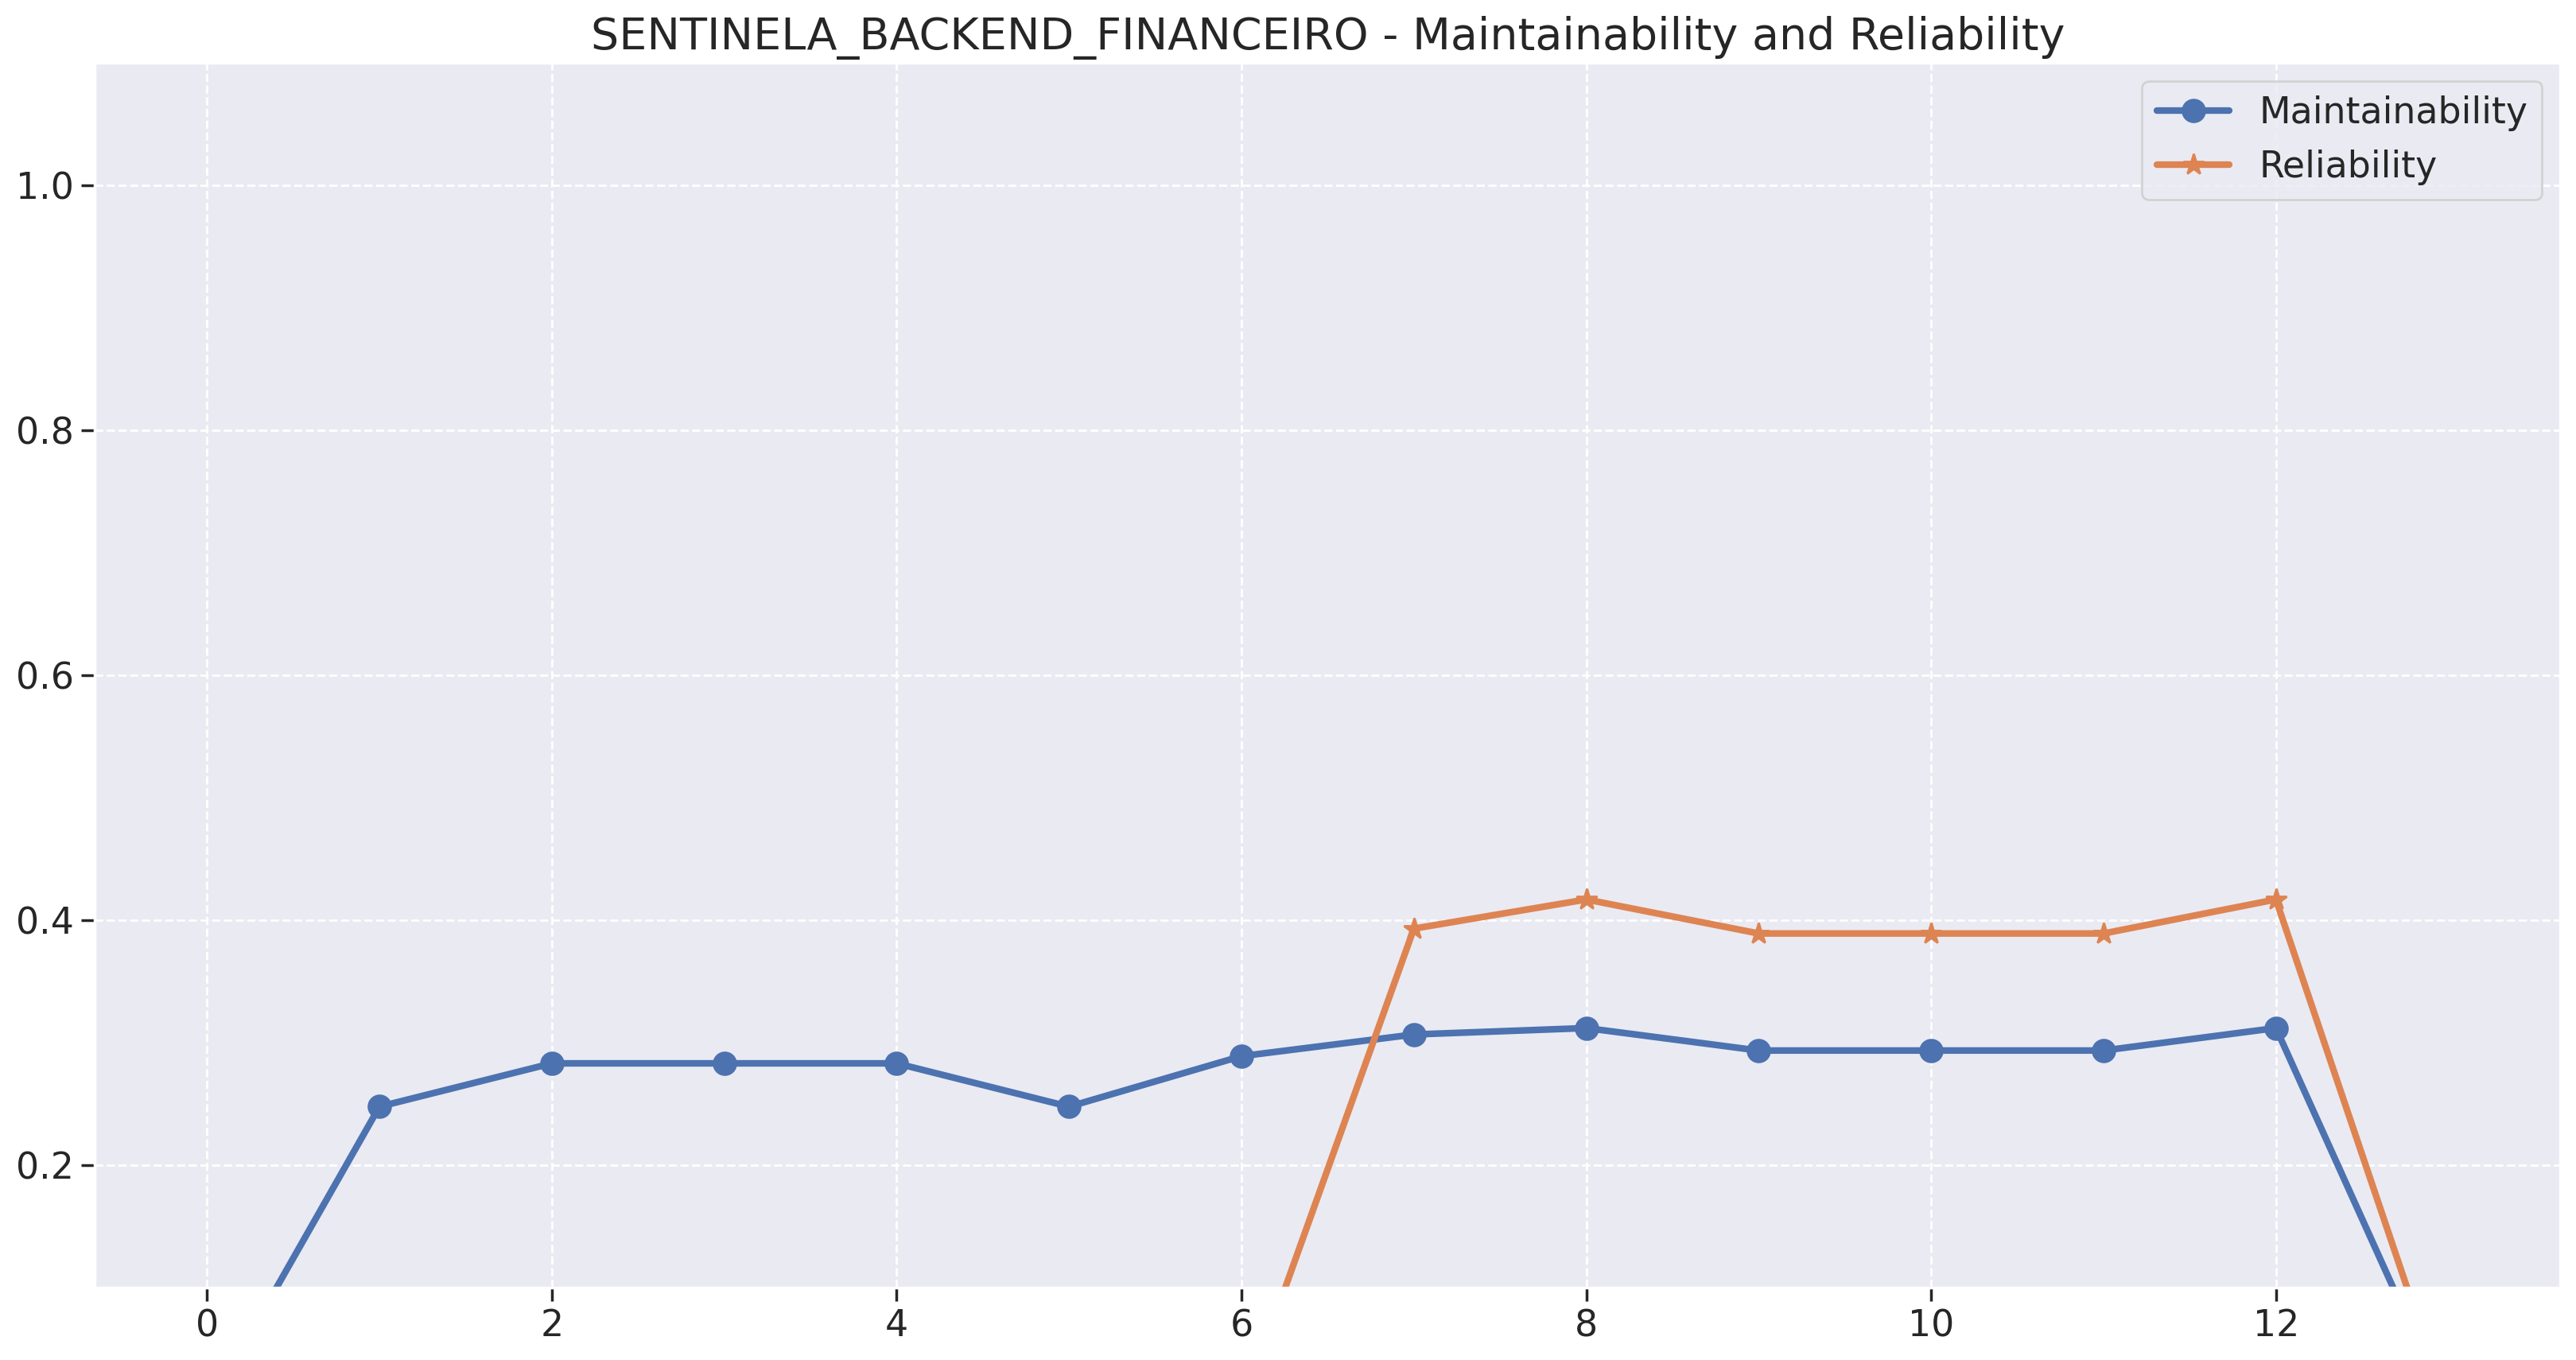

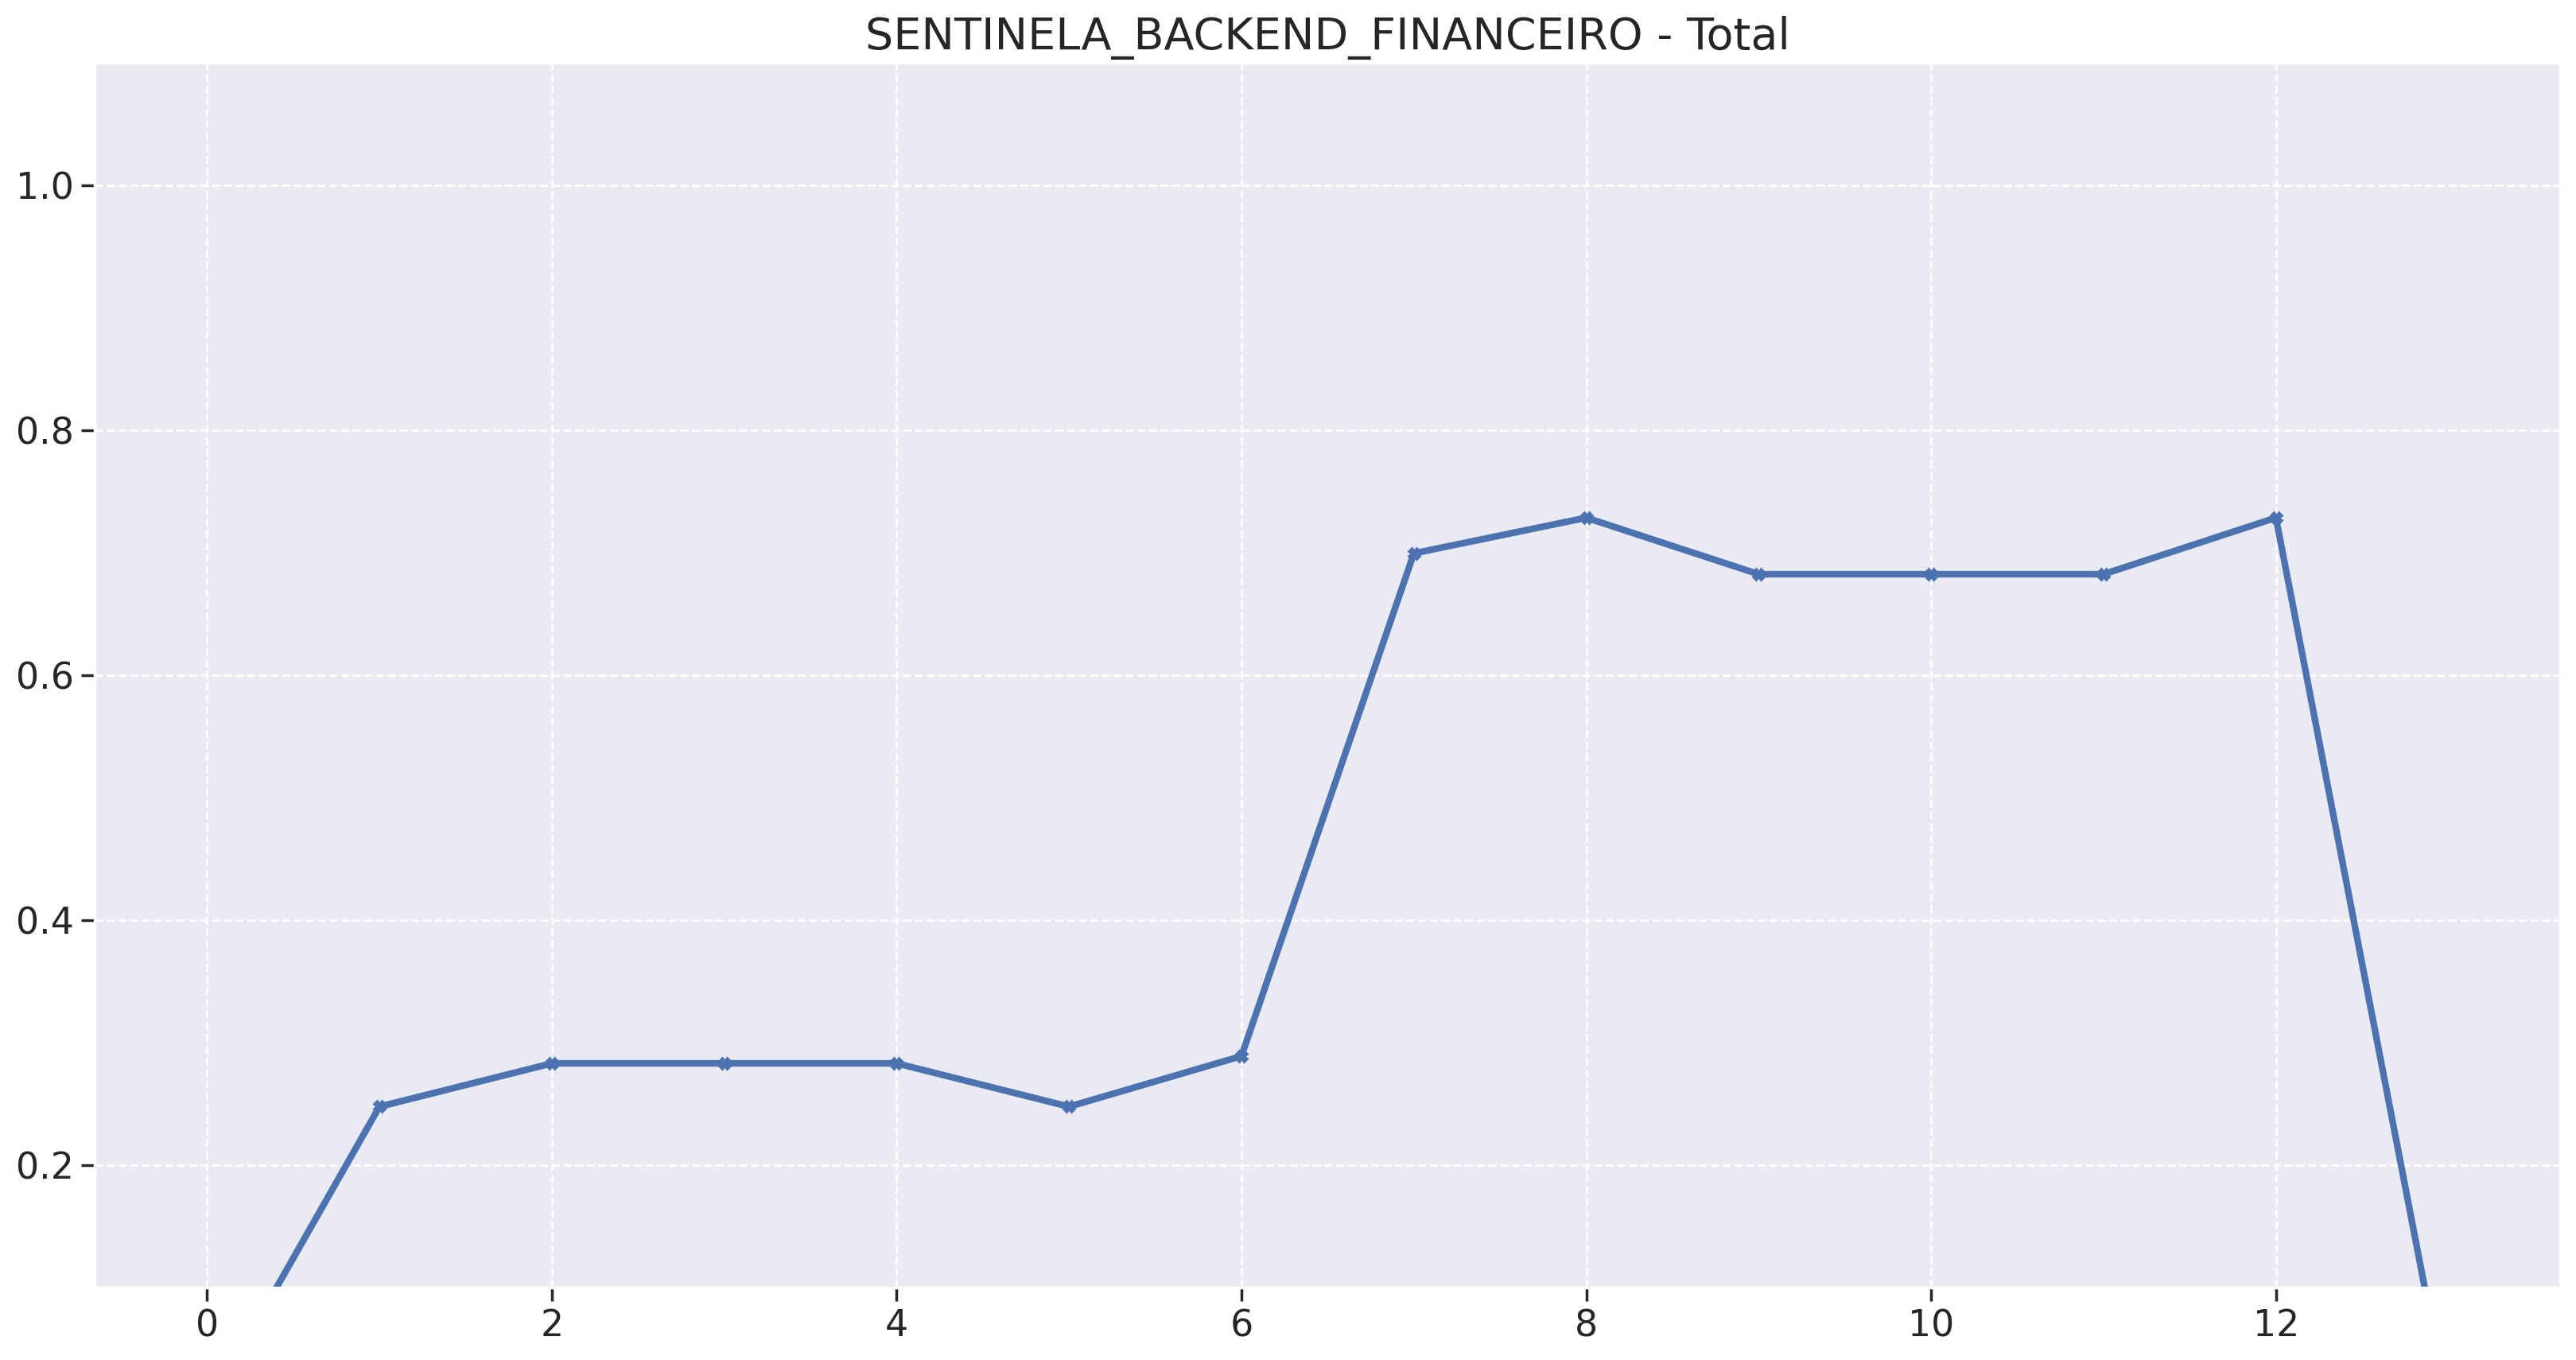

SENTINELA_BACKEND_BENEFICIOS
Maintainability Stats
    mean     mode  median      std     var  min      max
0.224583 0.309375 0.28875 0.129808 0.01685  0.0 0.309375
Reliability Stats
 mean  mode  median    std      var  min   max
0.125   0.0     0.0 0.1875 0.035156  0.0 0.375


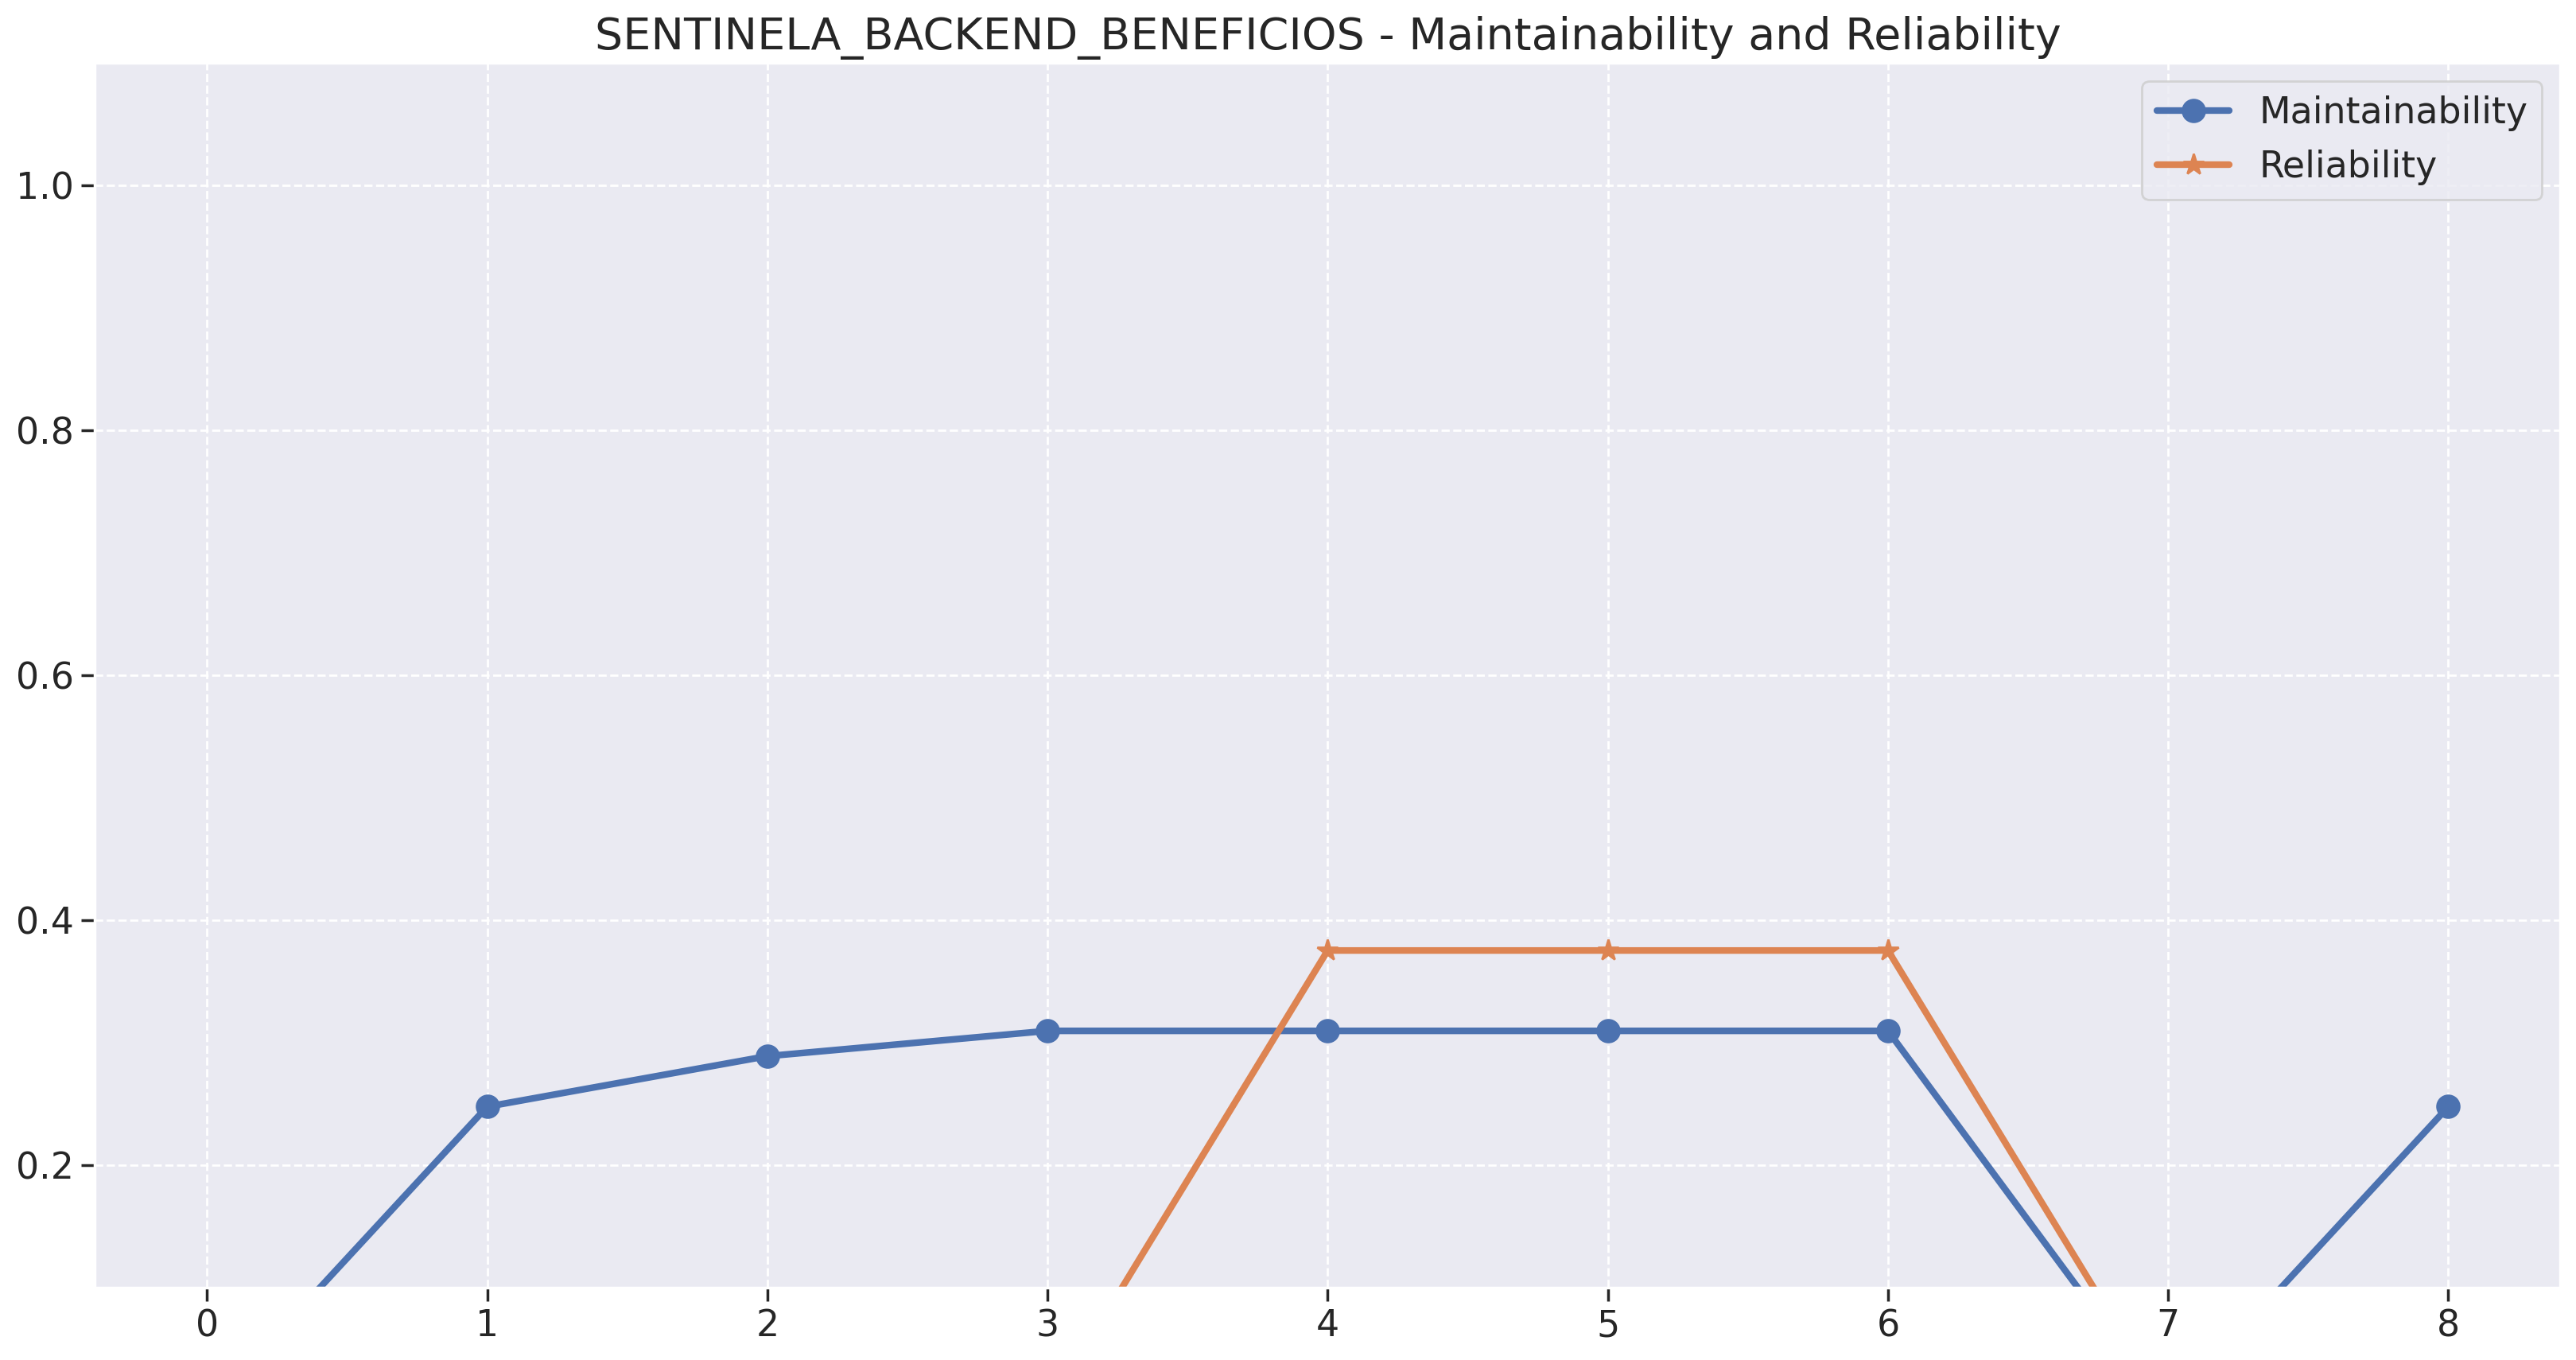

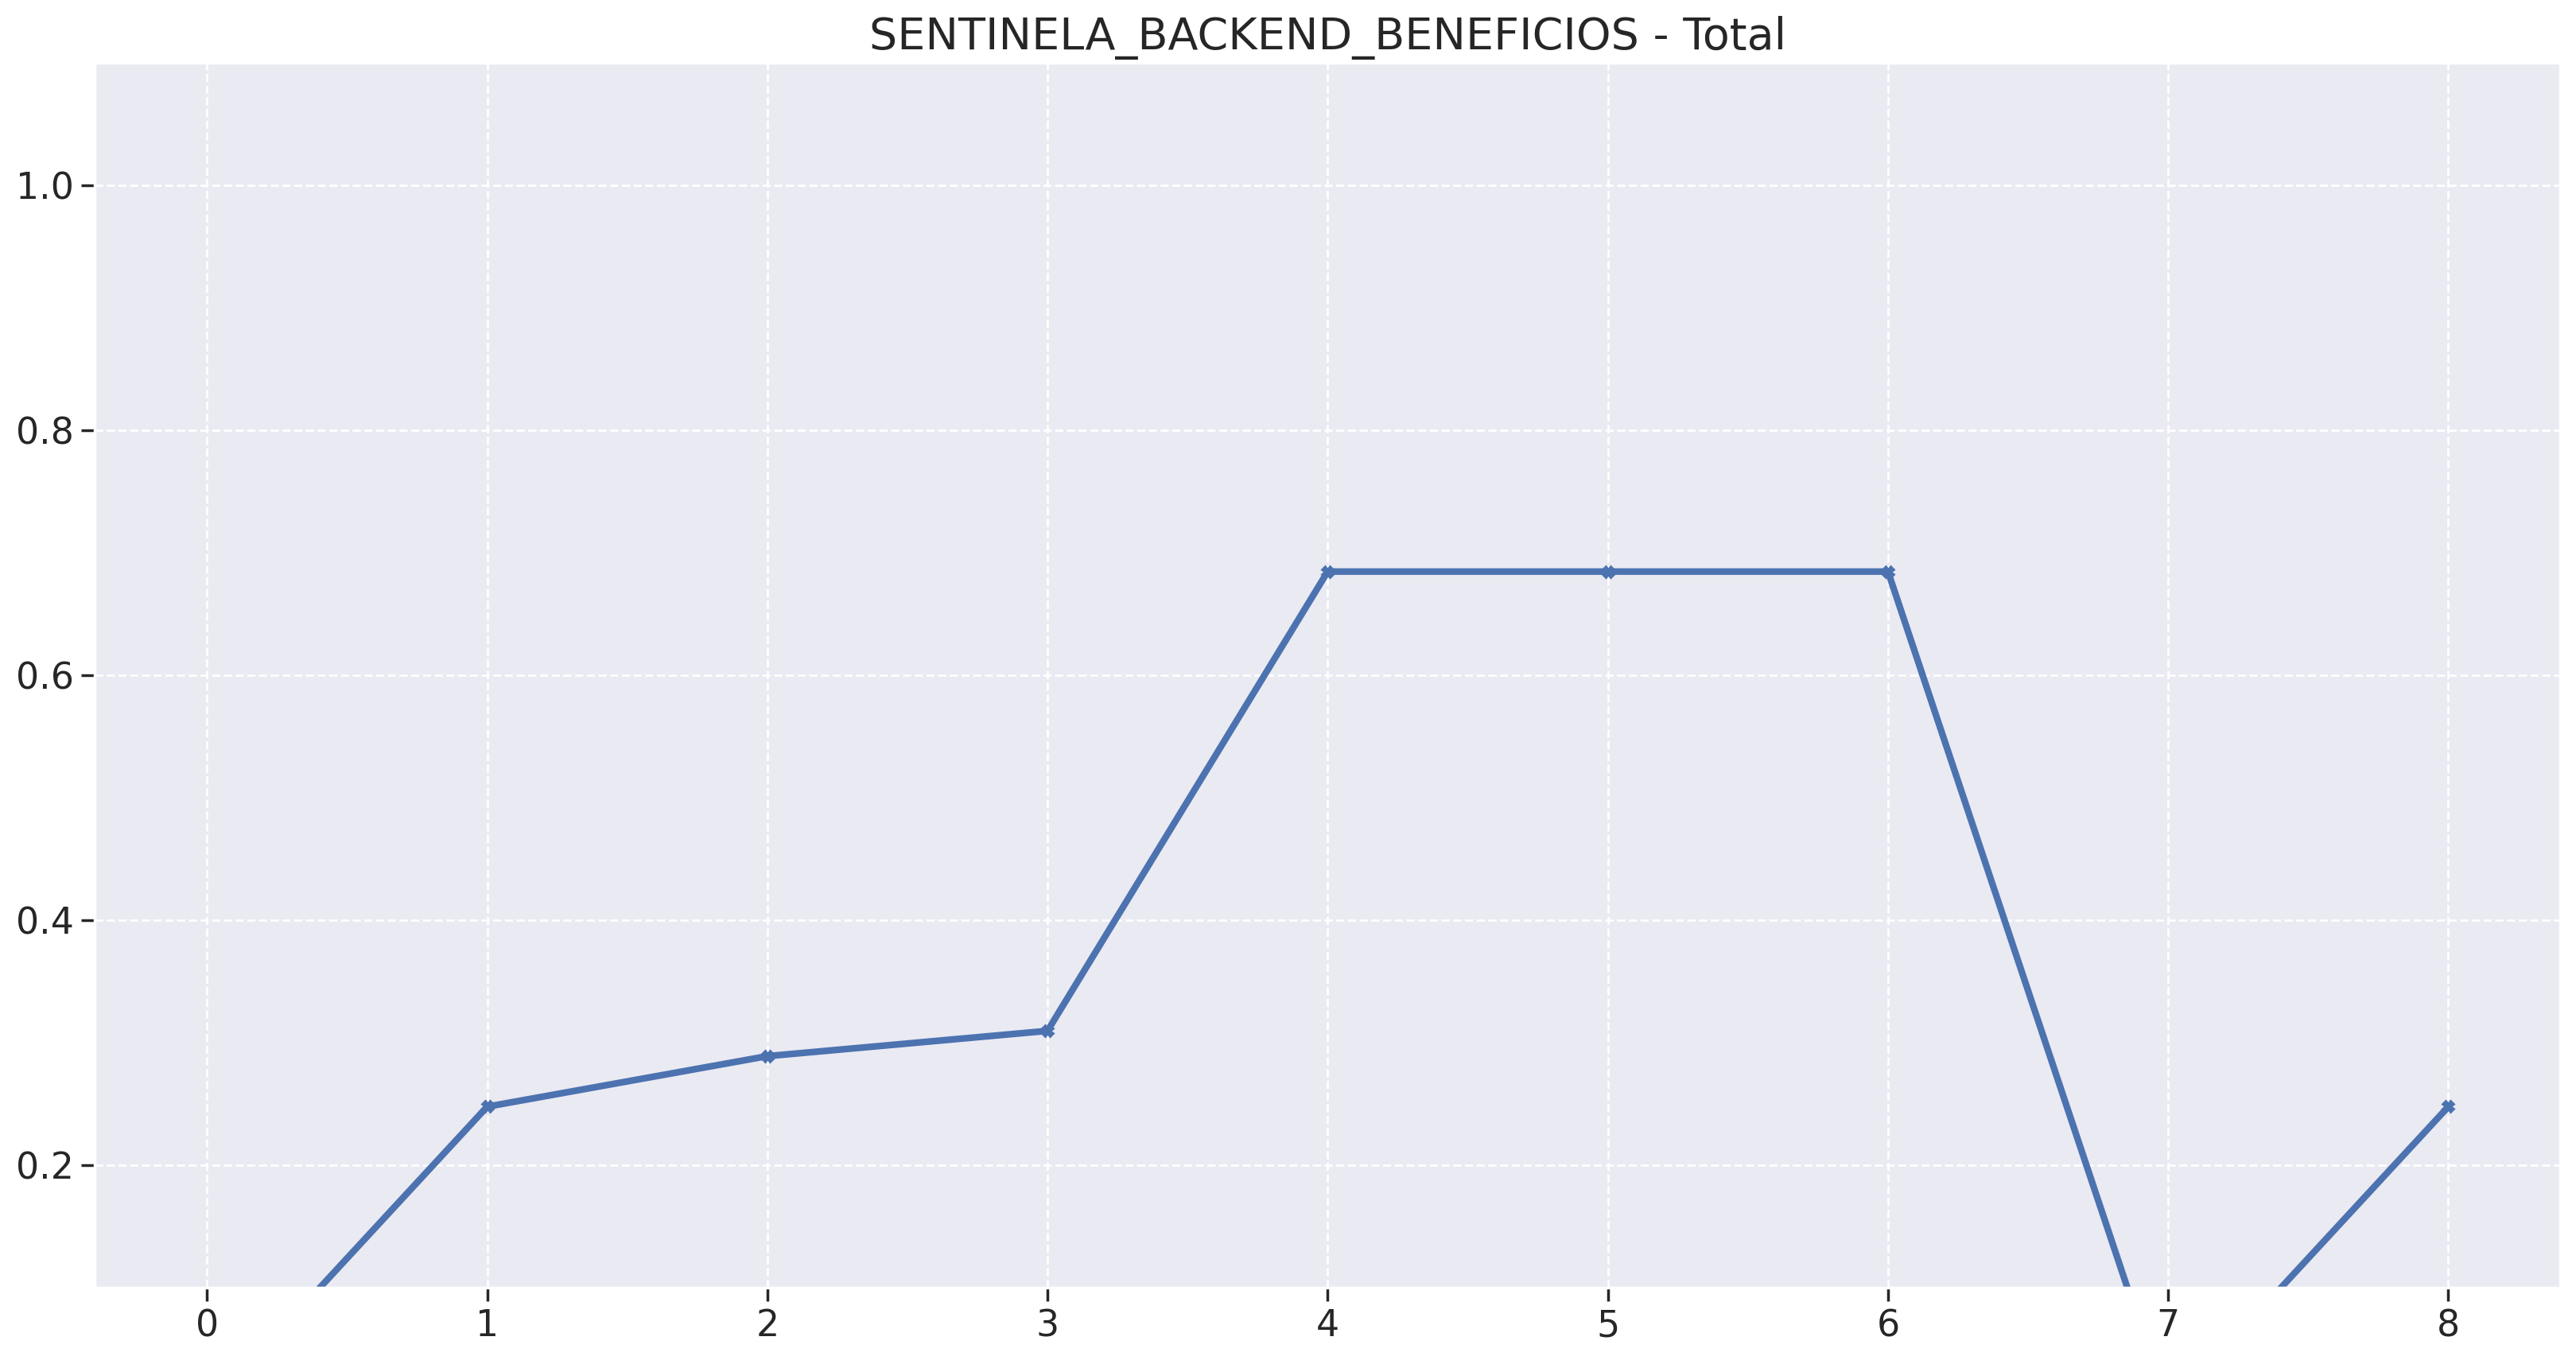

SENTINELA_FRONT
Maintainability Stats
    mean     mode   median      std      var  min  max
0.238765 0.000000 0.321538 0.146645 0.021505  0.0 0.33
0.238765 0.325658 0.321538 0.146645 0.021505  0.0 0.33
Reliability Stats
    mean  mode   median      std      var  min      max
0.210195   0.0 0.269737 0.148616 0.022087  0.0 0.378205


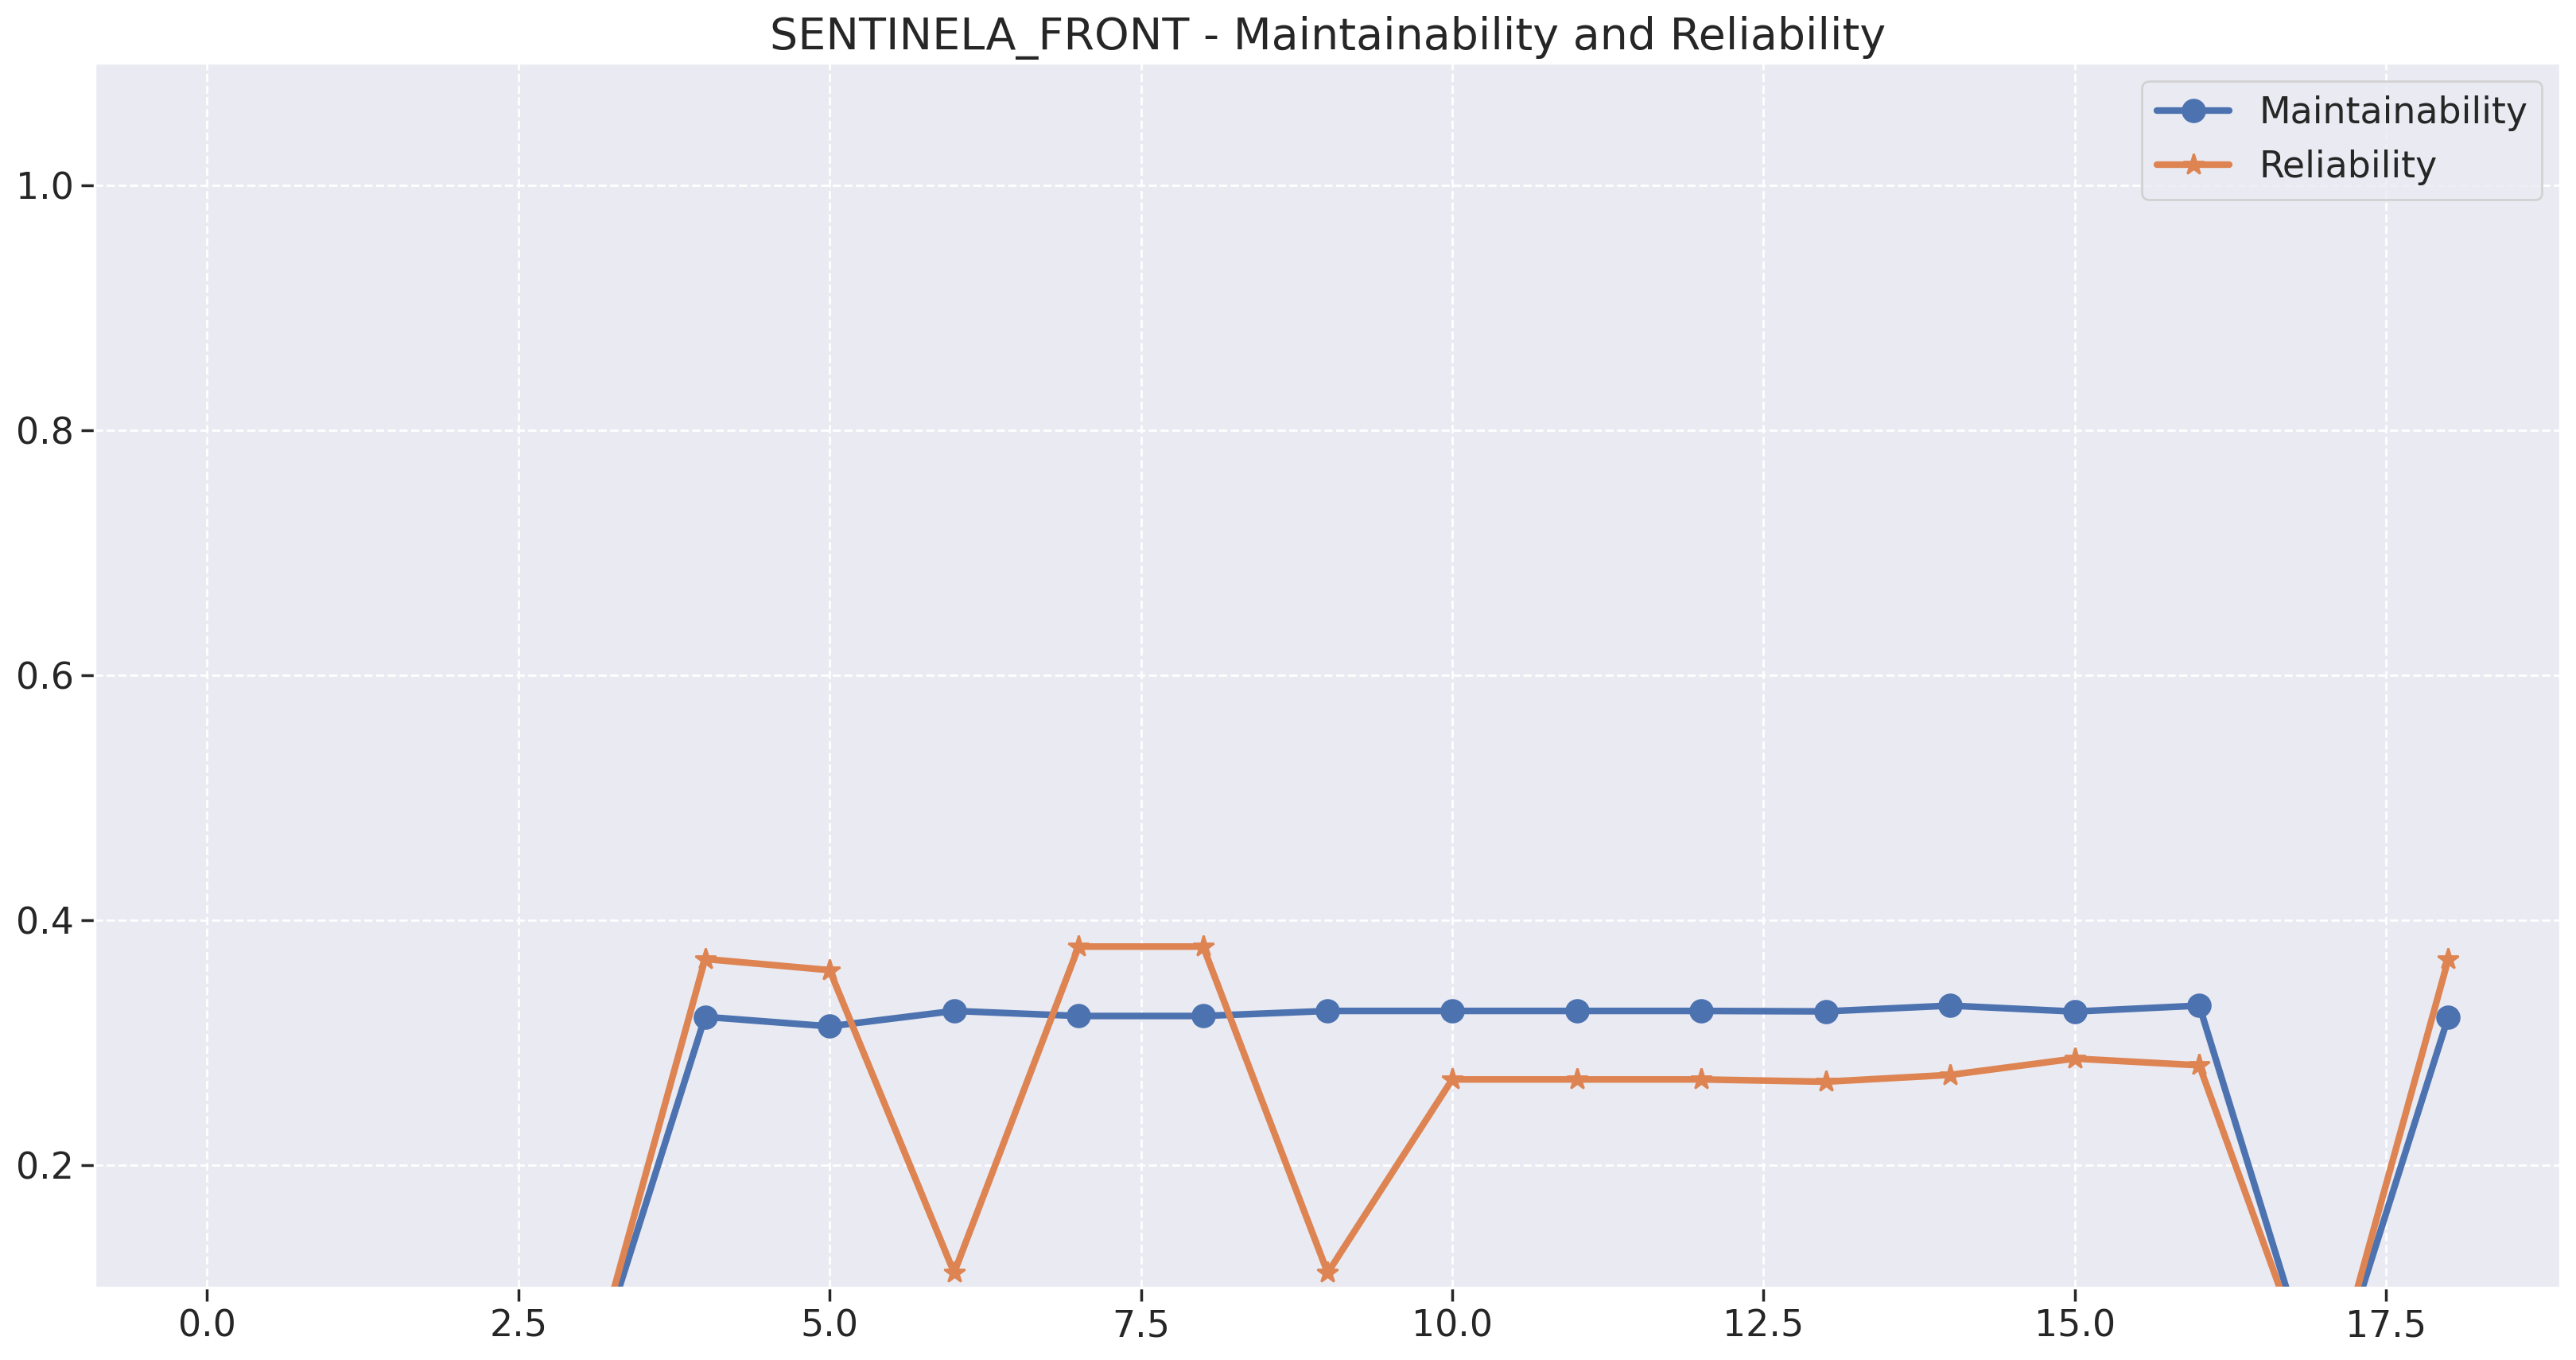

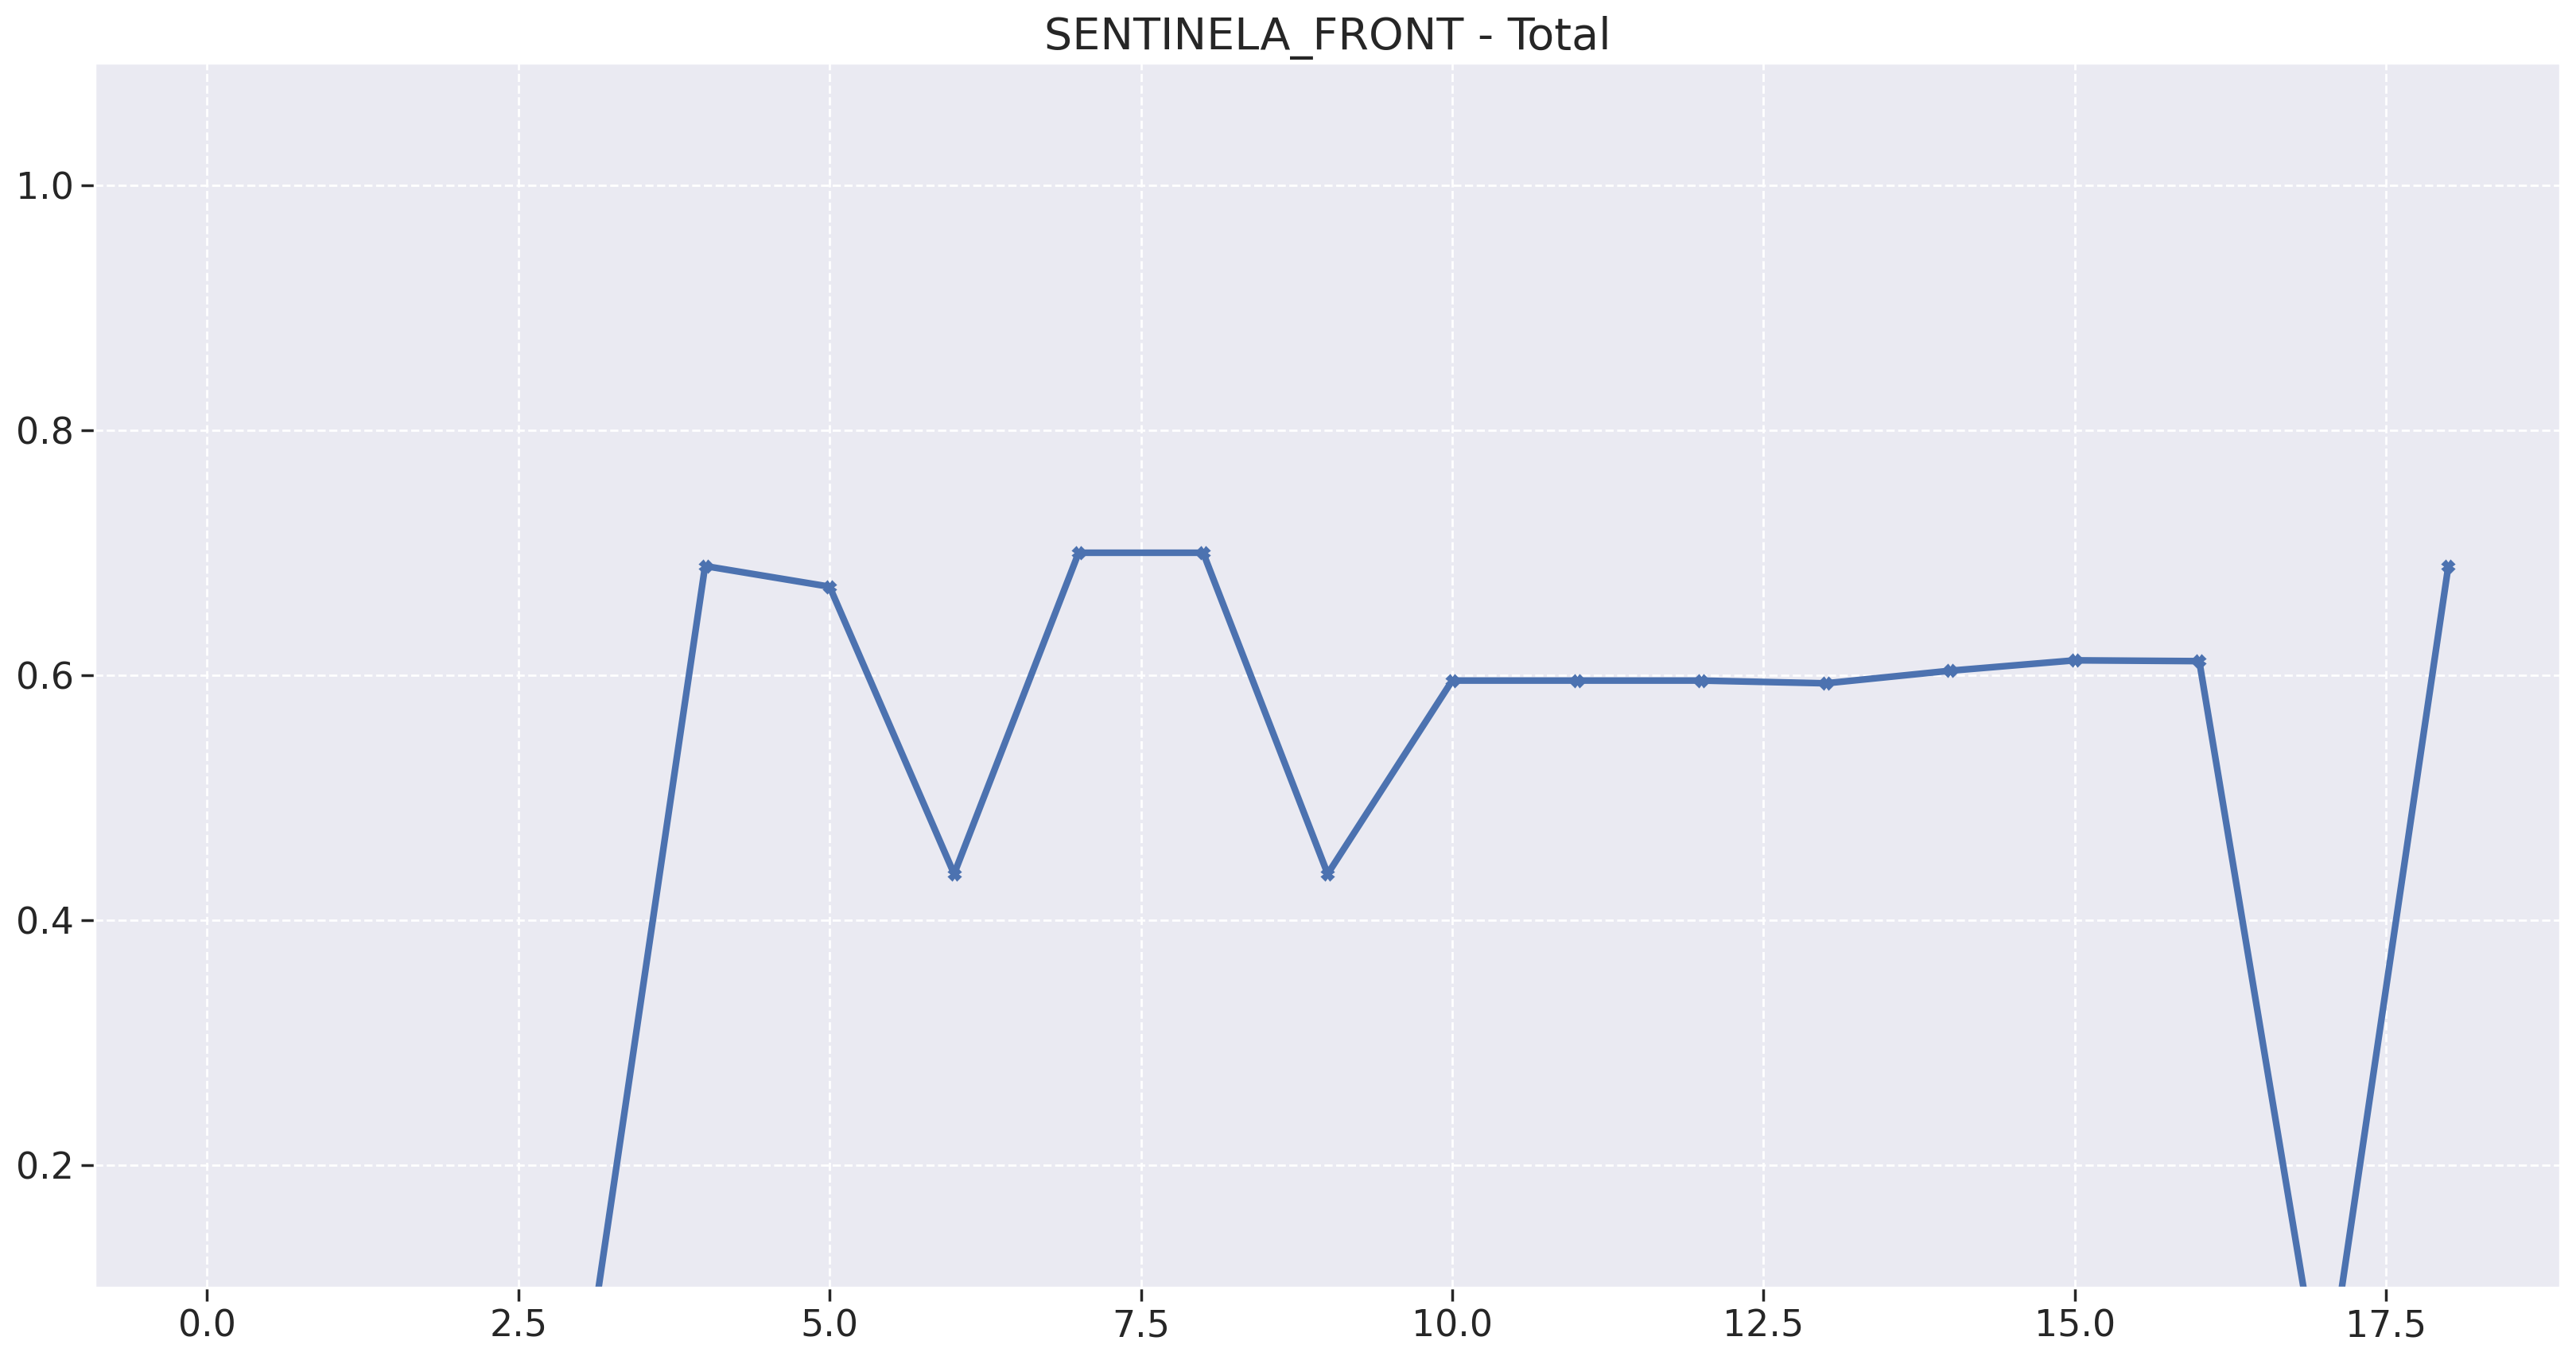

In [98]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

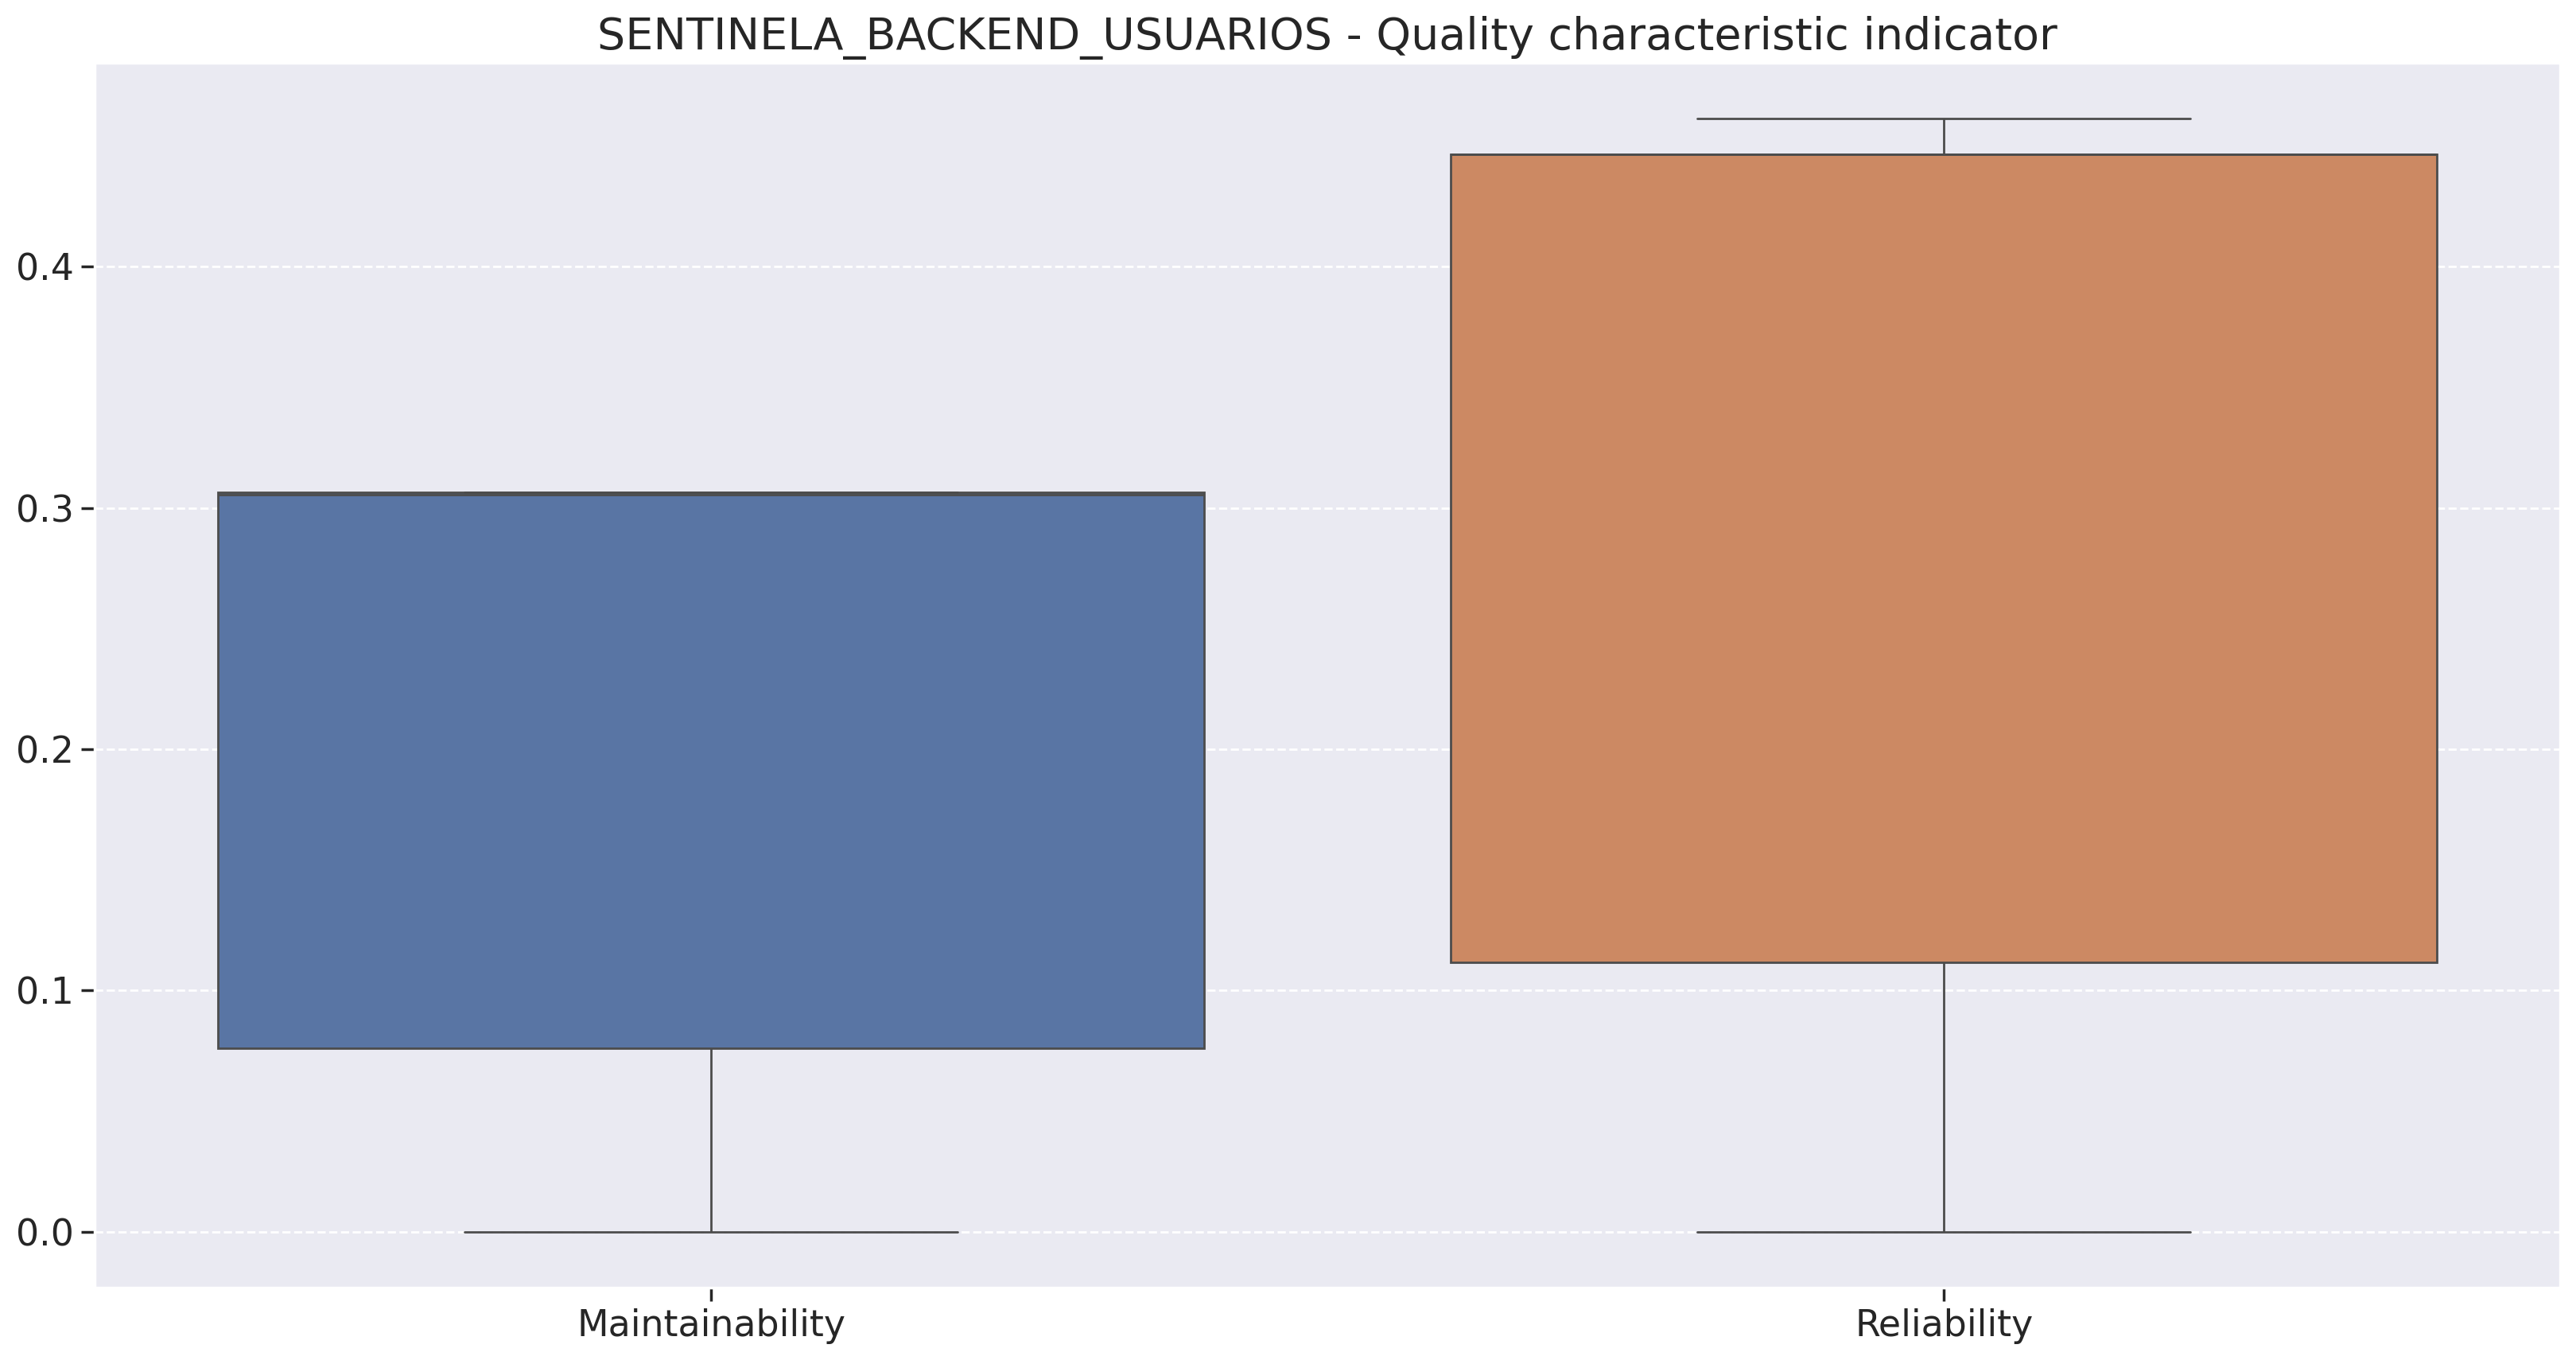

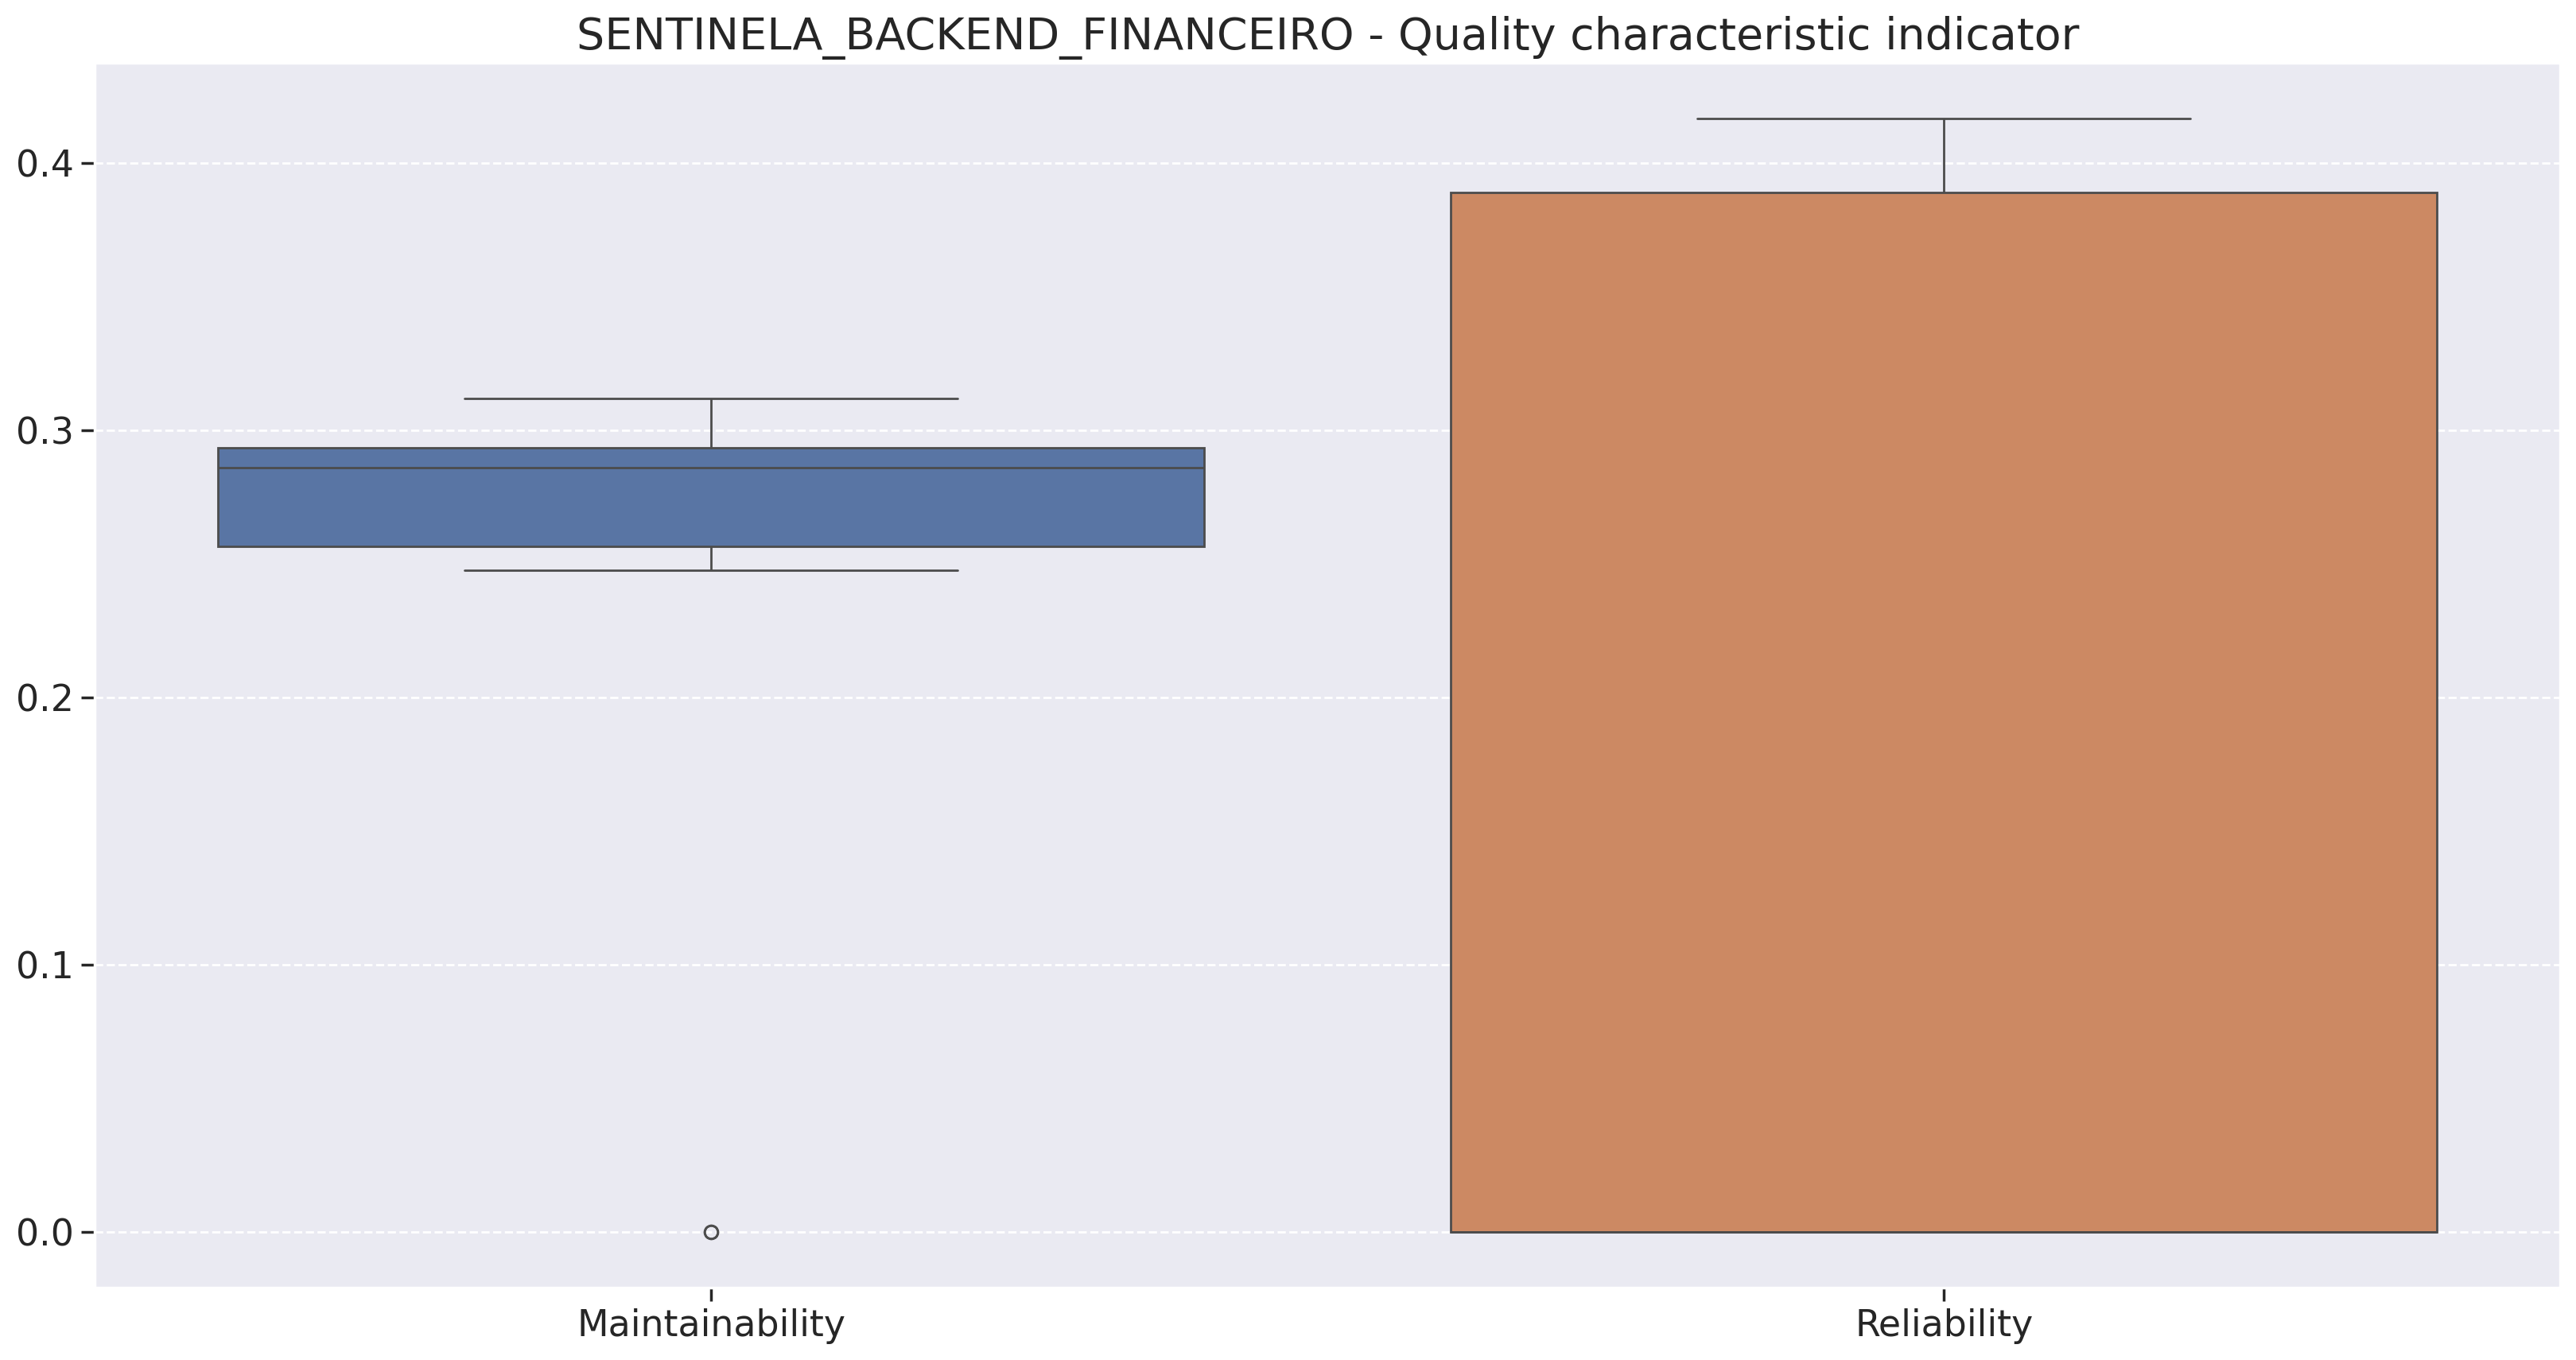

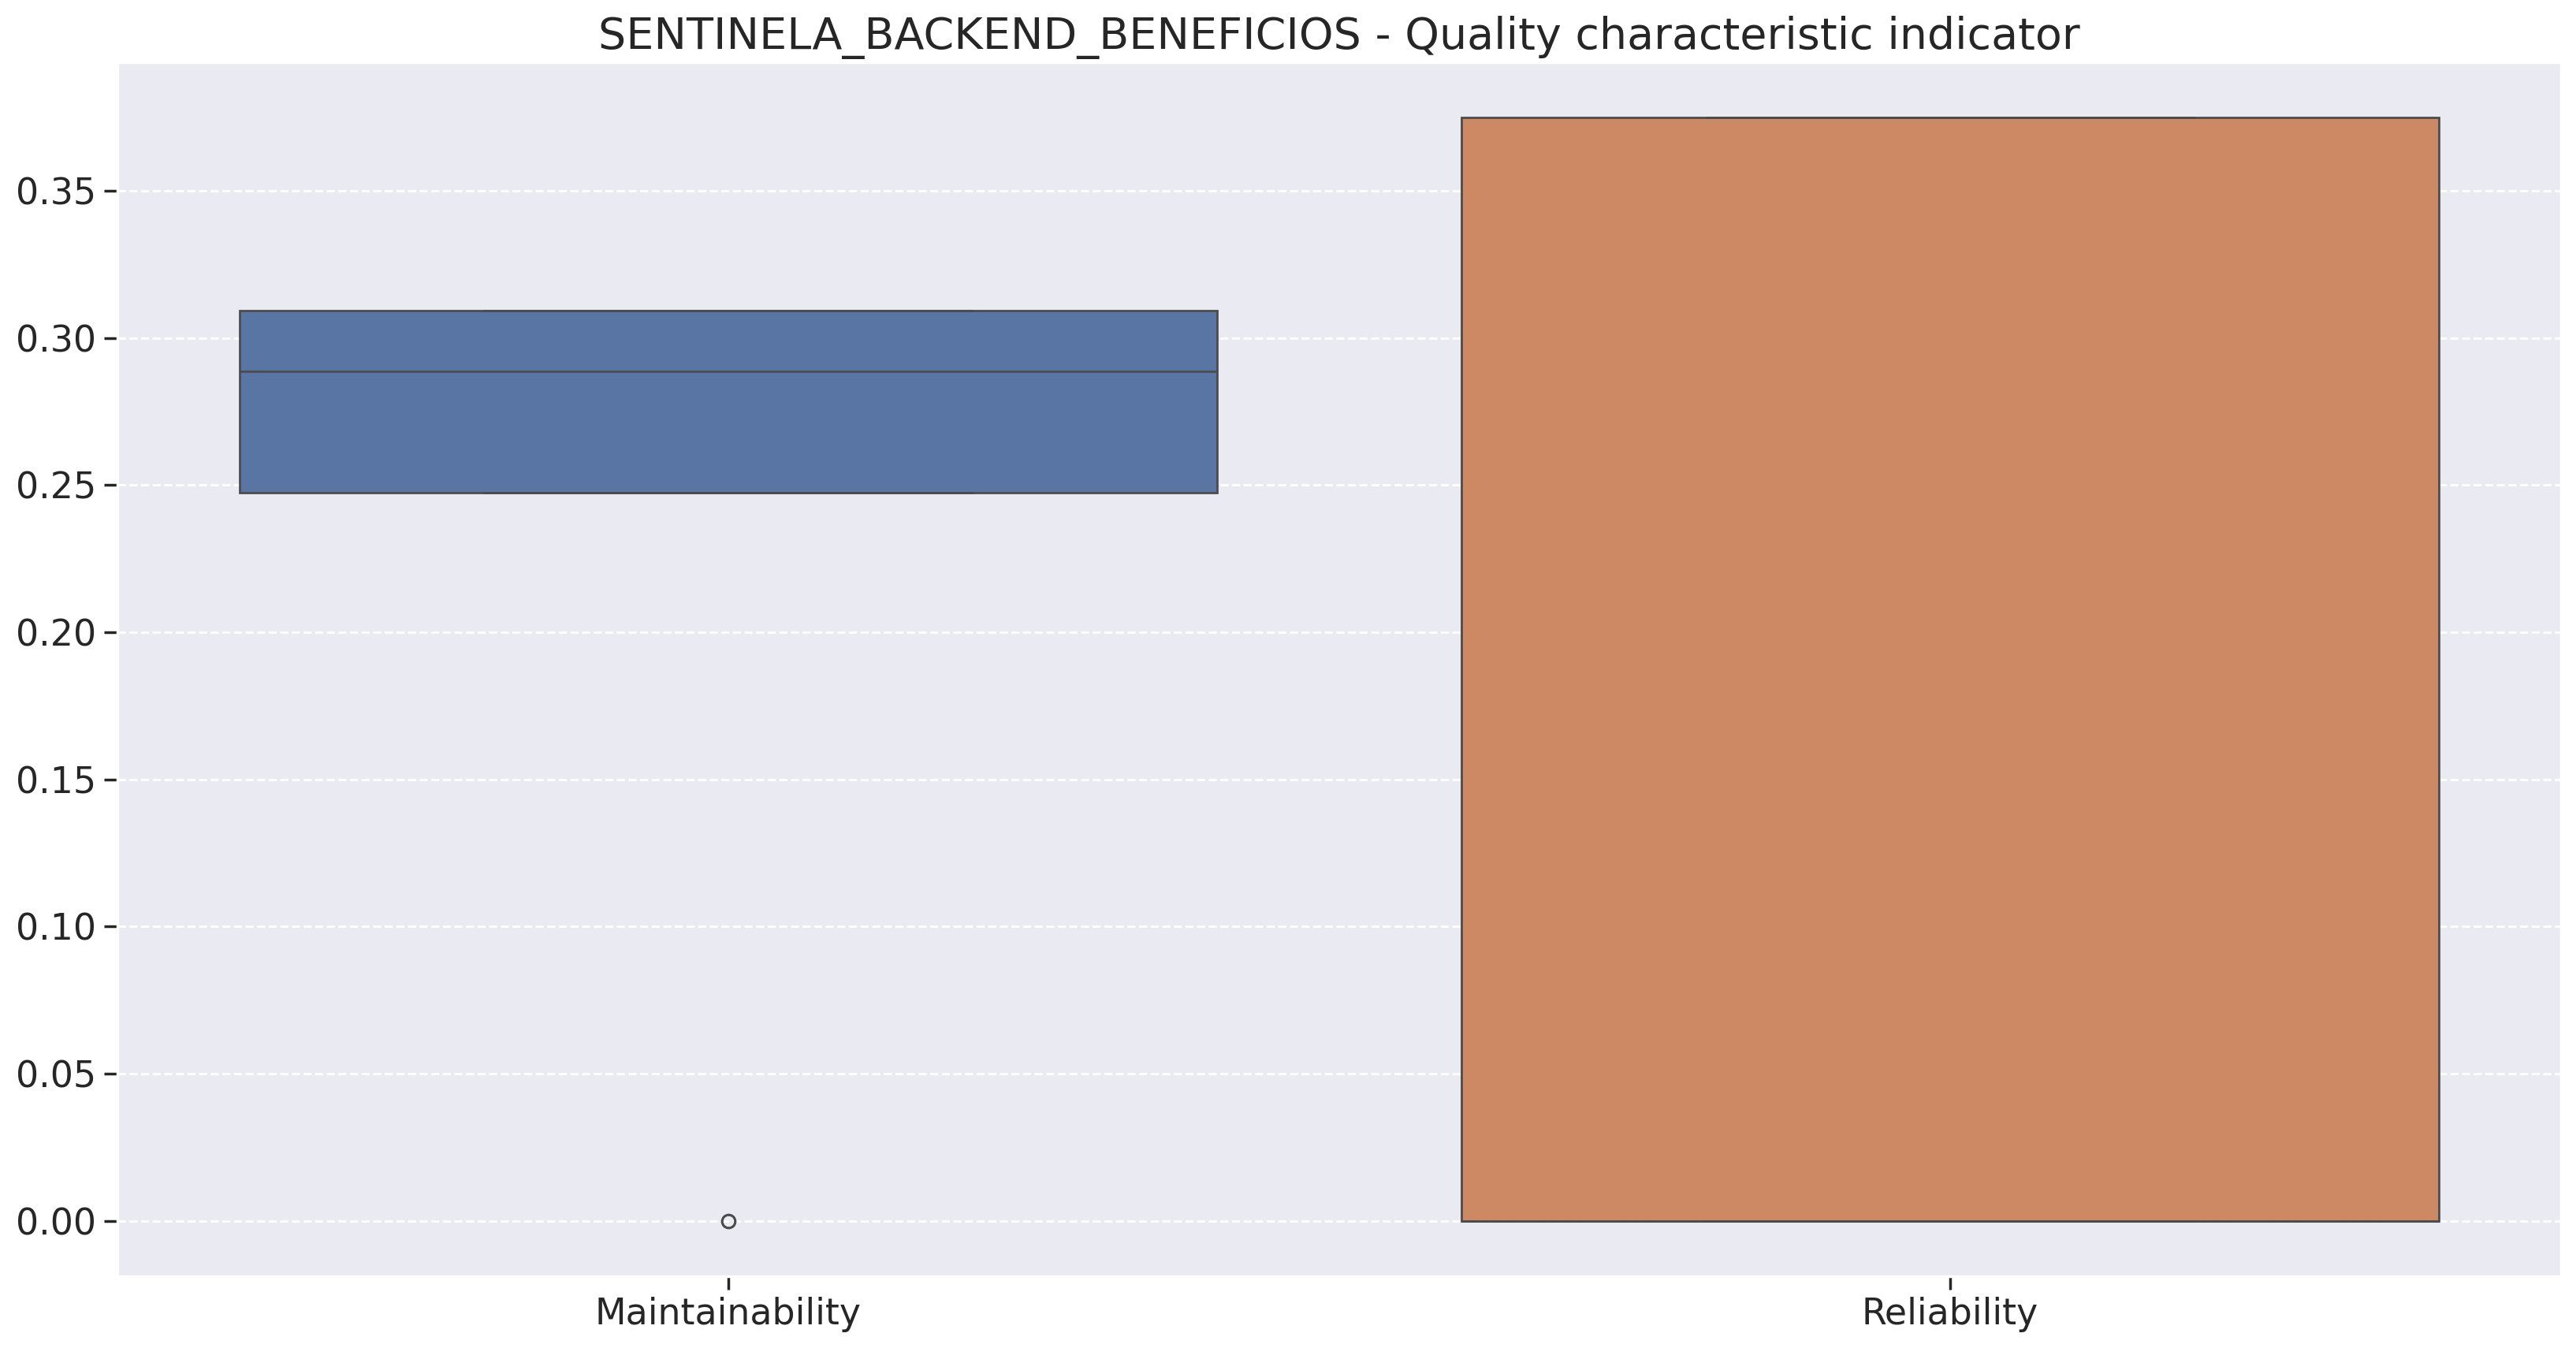

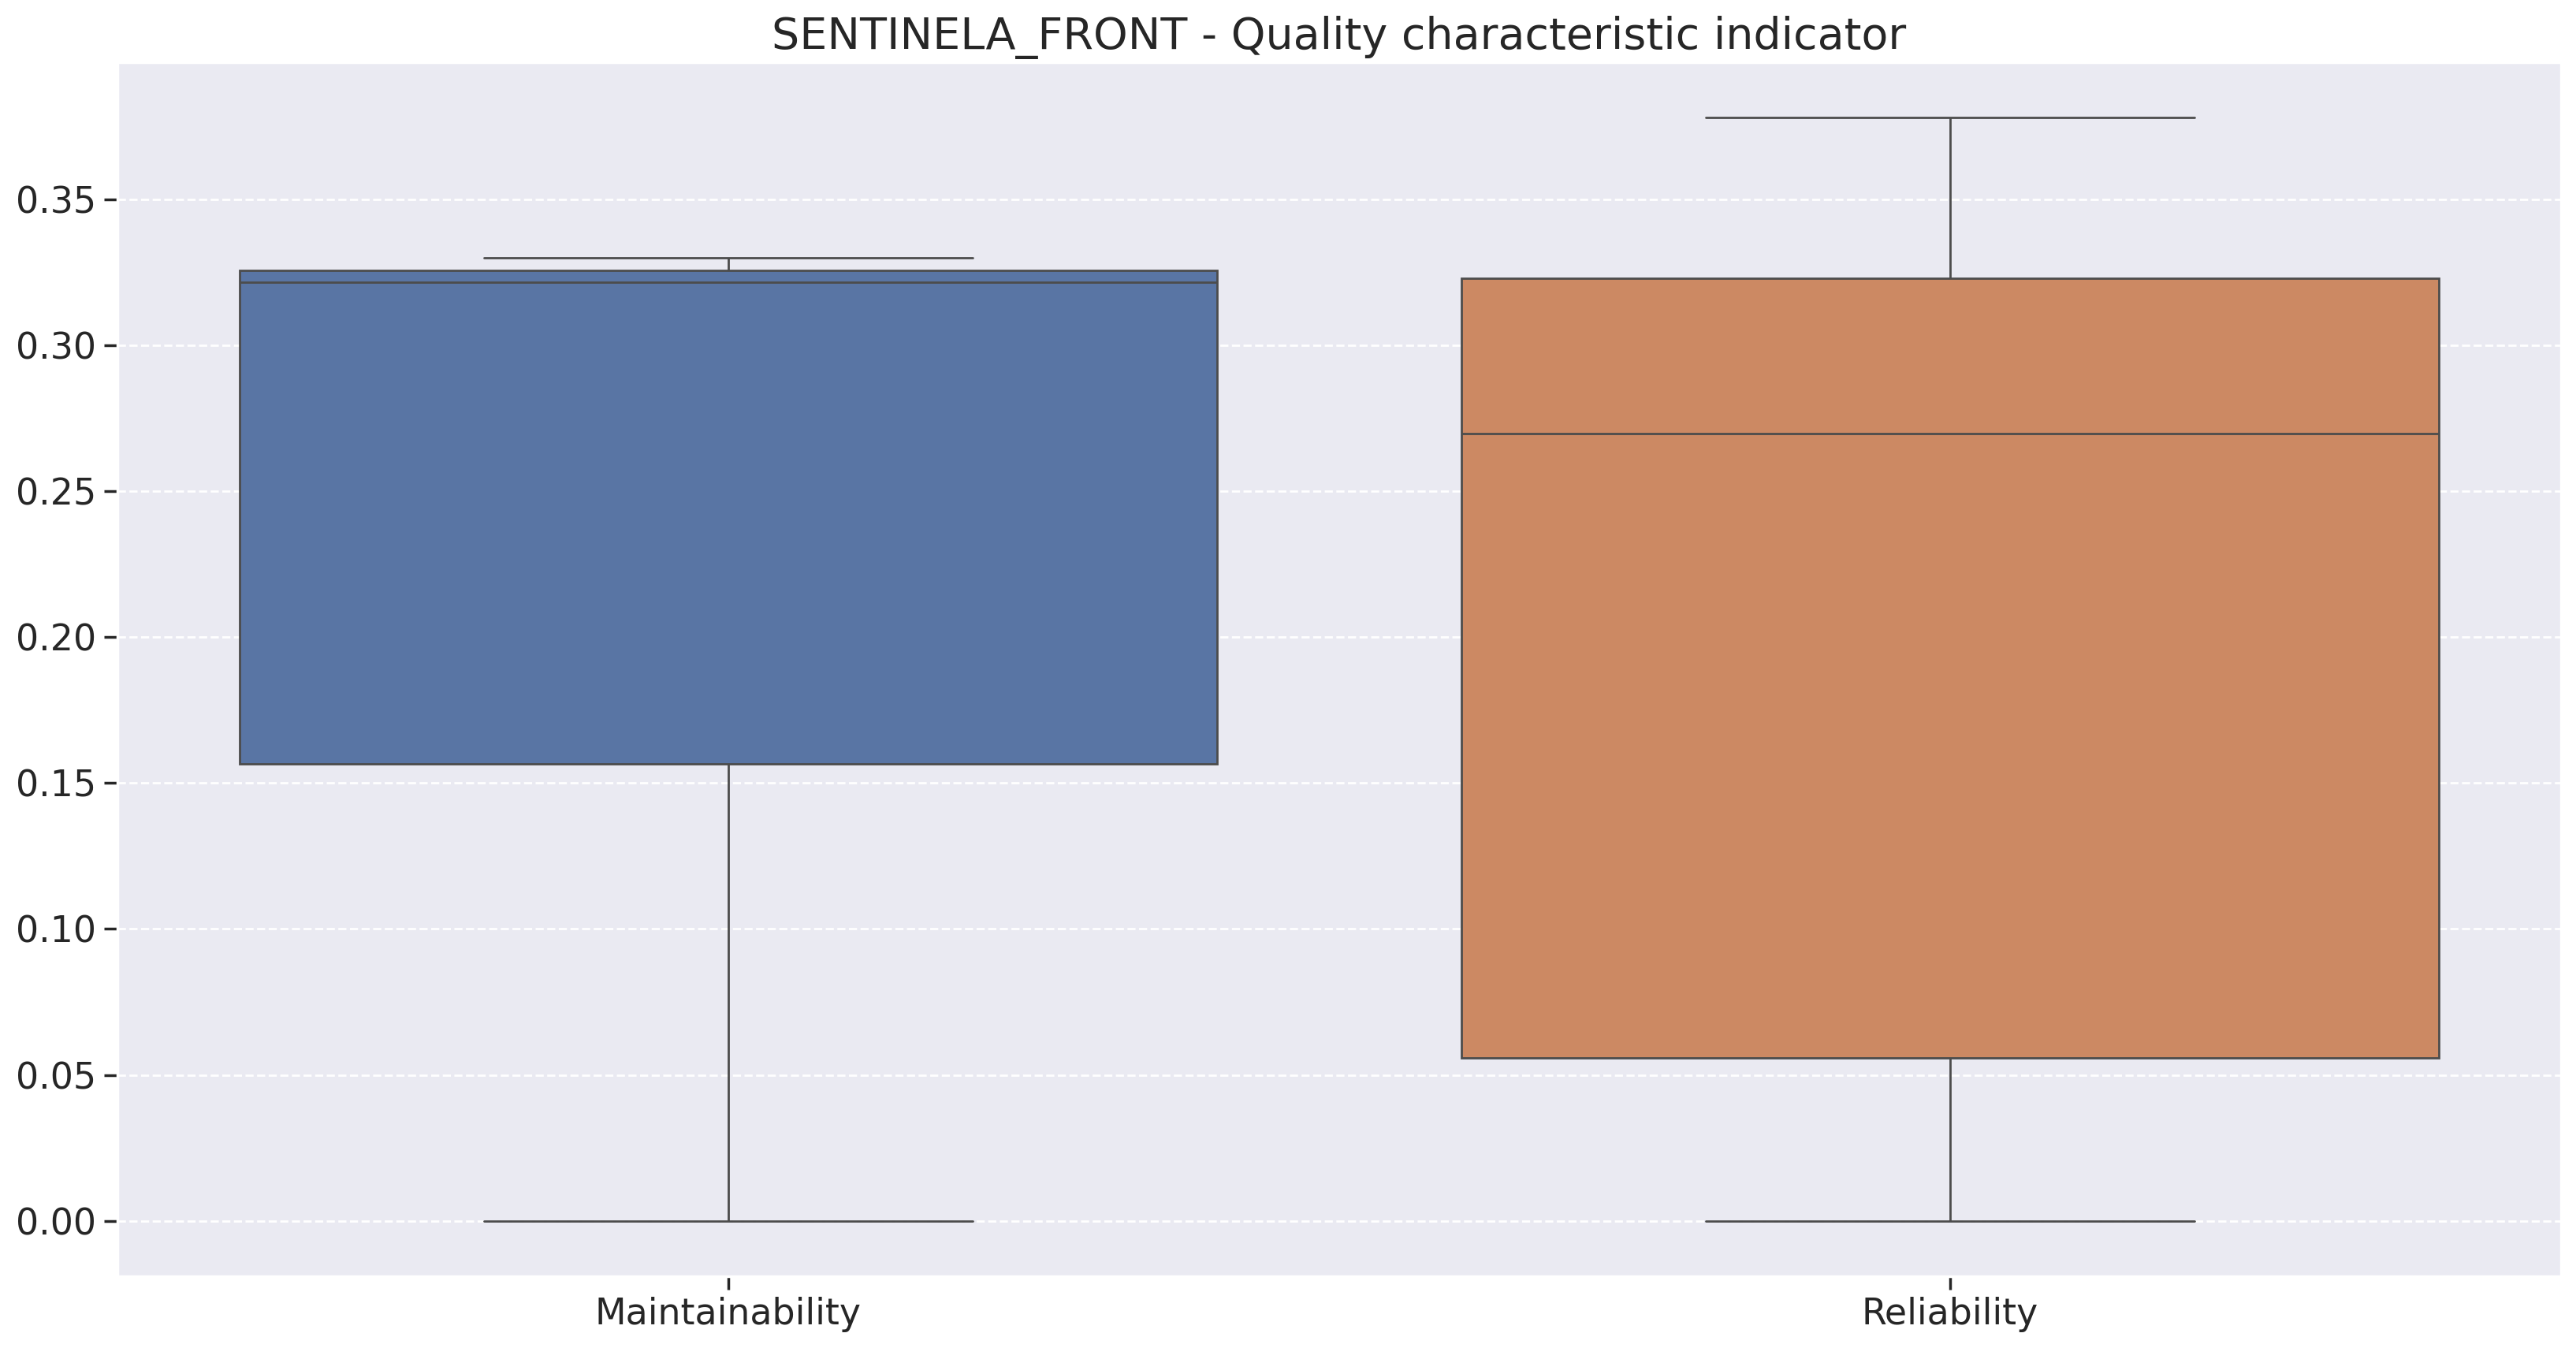

In [99]:

for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

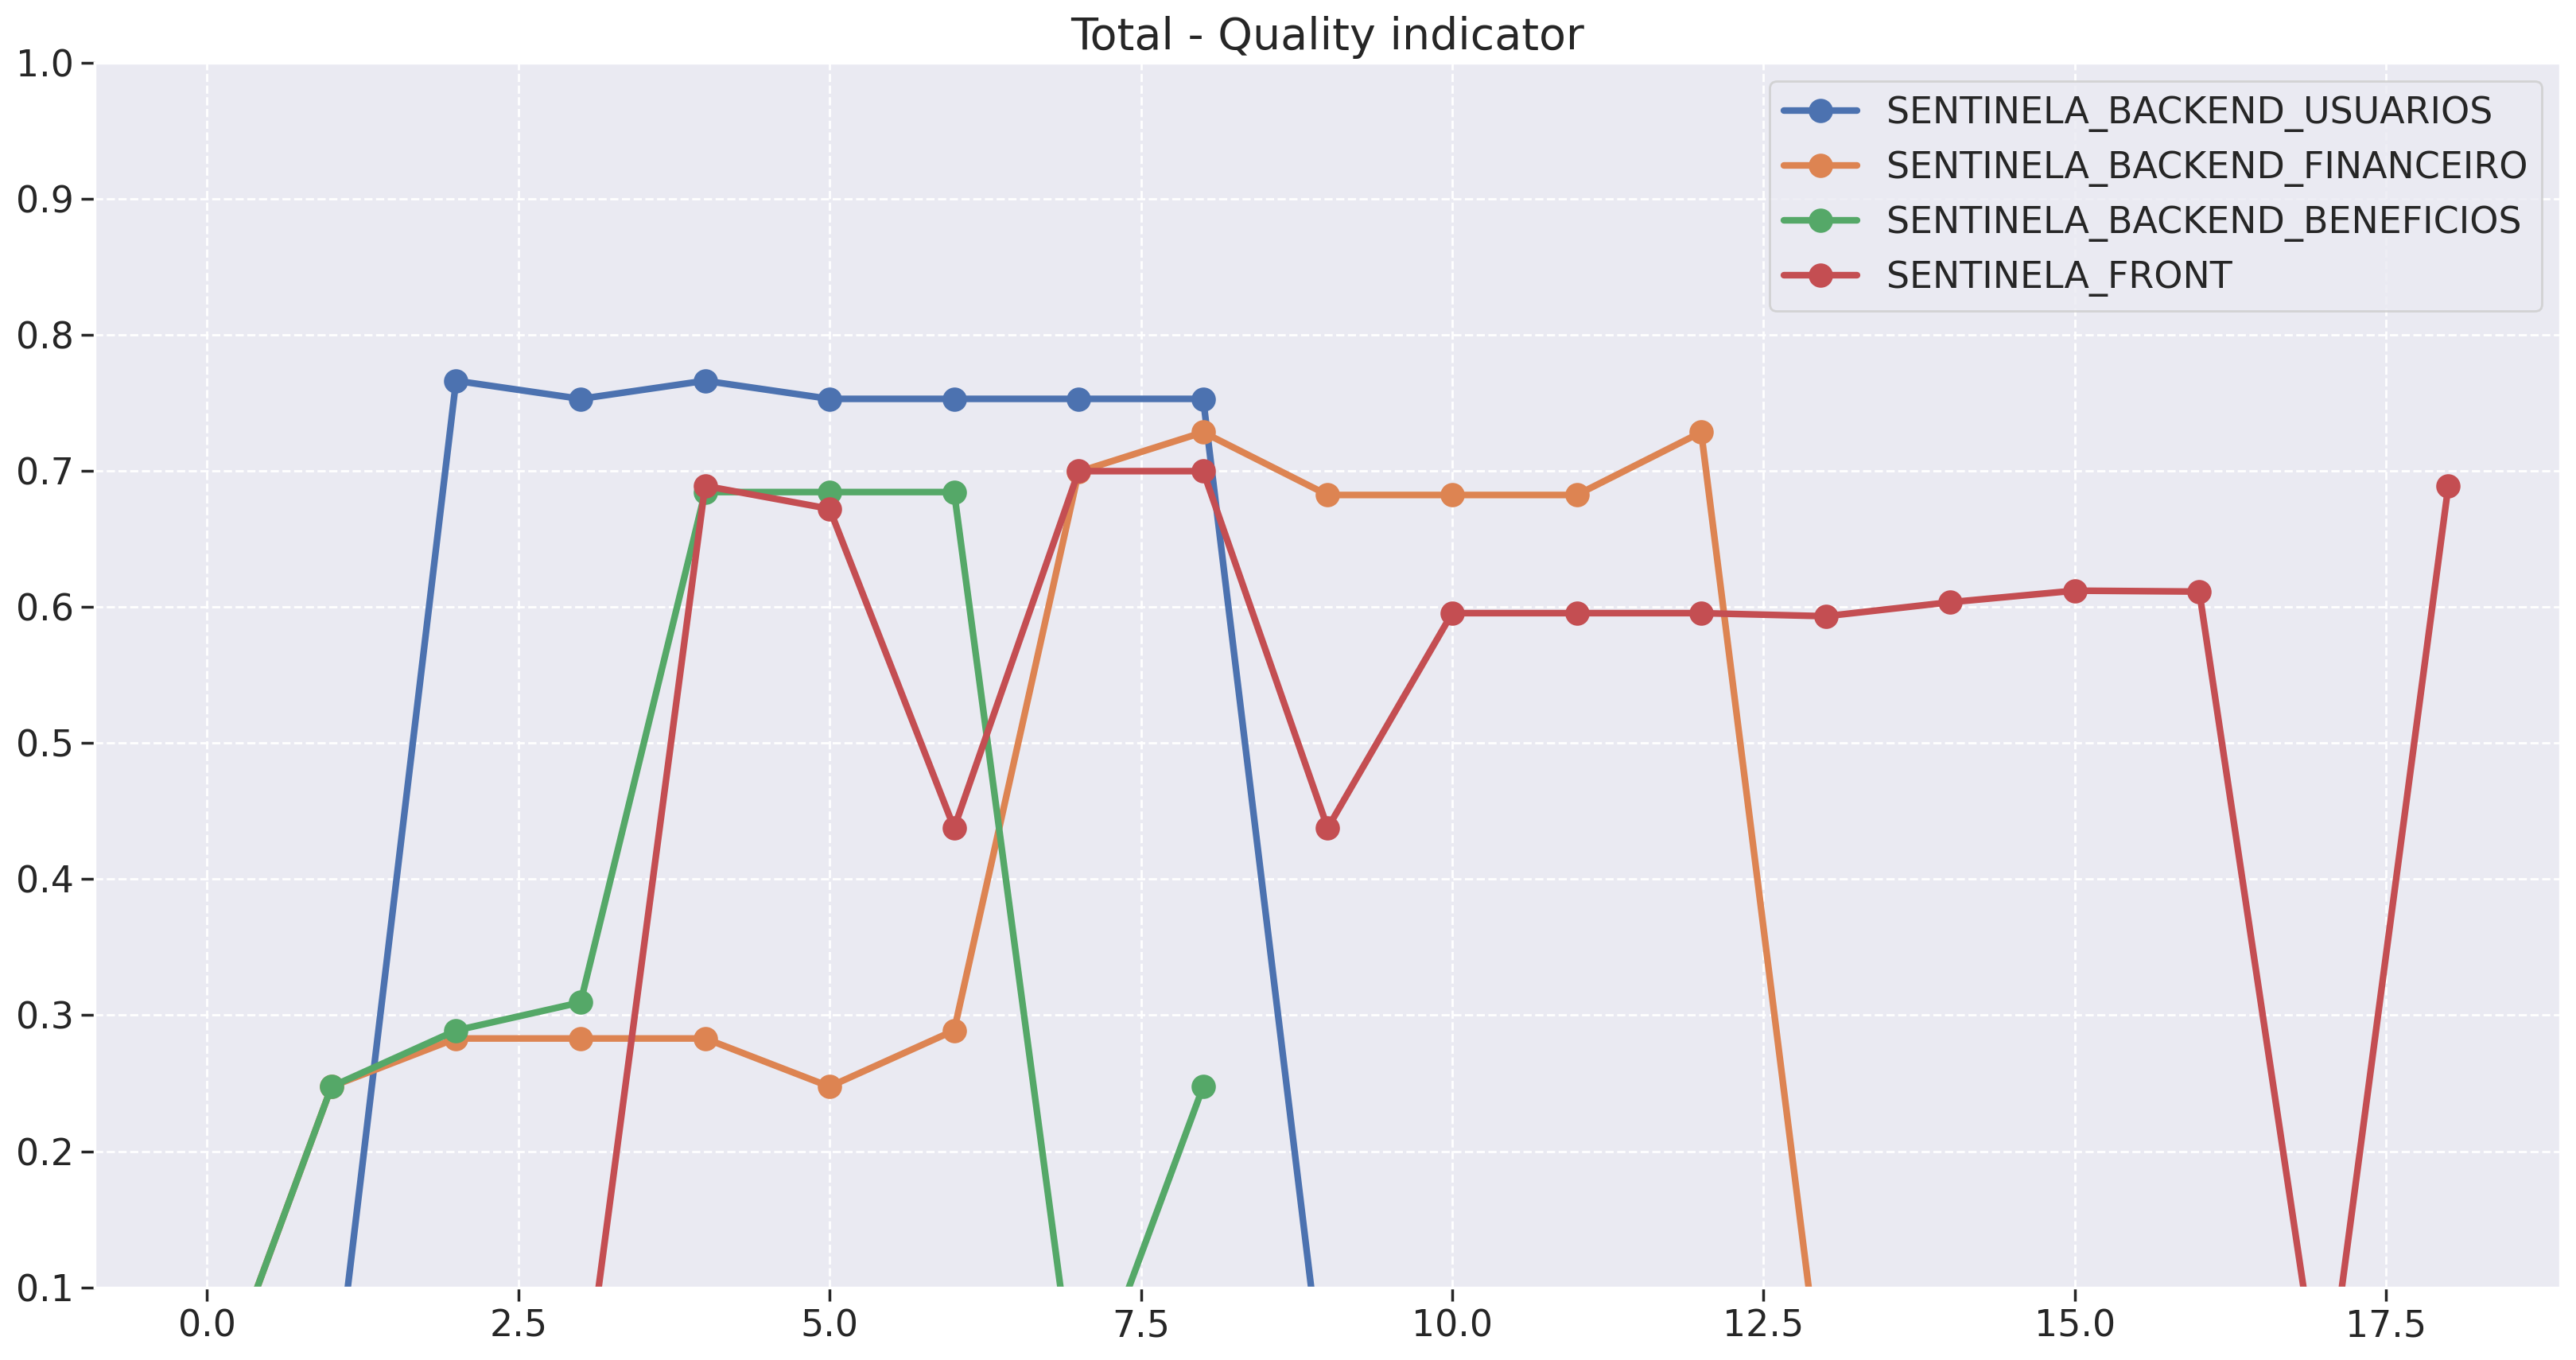

In [100]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [101]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('./data/fga-eps-mds-2024-1-SENTINELA--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('./data/fga-eps-mds-2024-1-SENTINELA--{}.csv'.format(current_datetime), index = False)

complexity  comments  duplication  test_success  fast_tests  coverage  \
0     0.000000  0.000000     0.000000           0.0         0.0  0.000000   
1     0.000000  0.000000     0.000000           0.0         0.0  0.000000   
2     0.692308  0.153846     1.000000           1.0         1.0  0.846154   
3     0.714286  0.142857     1.000000           1.0         1.0  0.785714   
4     0.692308  0.153846     1.000000           1.0         1.0  0.846154   
5     0.714286  0.142857     1.000000           1.0         1.0  0.785714   
6     0.714286  0.142857     1.000000           1.0         1.0  0.785714   
7     0.714286  0.142857     1.000000           1.0         1.0  0.785714   
8     0.714286  0.142857     1.000000           1.0         1.0  0.785714   
9     0.000000  0.000000     0.000000           0.0         0.0  0.000000   
10    0.000000  0.000000     0.000000           0.0         0.0  0.000000   
11    0.500000  0.000000     1.000000           0.0         0.0  0.000000   
12    0.428571  0.285714     1.000000           0.0         0.0  0.000000   
13    0.428571  0.285714     1.000000           0.0         0.0  0.000000   
14    0.428571  0.285714     1.000000           0.0         0.0  0.000000   
15    0.500000  0.000000     1.000000           0.0         0.0  0.000000   
16    0.500000  0.250000     1.000000           0.0         0.0  0.000000   
17    0.571429  0.285714     1.000000           1.0         1.0  0.571429   
18    0.555556  0.333333     1.000000           1.0         1.0  0.666667   
19    0.444444  0.333333     1.000000           1.0         1.0  0.555556   
20    0.444444  0.333333     1.000000           1.0         1.0  0.555556   
21    0.444444  0.333333     1.000000           1.0         1.0  0.555556   
22    0.555556  0.333333     1.000000           1.0         1.0  0.666667   
23    0.000000  0.000000     0.000000           0.0         0.0  0.000000   
24    0.000000  0.000000     0.000000           0.0         0.0  0.000000   
25    0.500000  0.000000     1.000000           0.0         0.0  0.000000   
26    0.625000  0.125000     1.000000           0.0         0.0  0.000000   
27    0.625000  0.250000     1.000000           0.0         0.0  0.000000   
28    0.625000  0.250000     1.000000           1.0         1.0  0.500000   
29    0.625000  0.250000     1.000000           1.0         1.0  0.500000   
30    0.625000  0.250000     1.000000           1.0         1.0  0.500000   
31    0.000000  0.000000     0.000000           0.0         0.0  0.000000   
32    0.500000  0.000000     1.000000           0.0         0.0  0.000000   
33    0.000000  0.000000     0.000000           0.0         0.0  0.000000   
34    0.000000  0.000000     0.000000           0.0         0.0  0.000000   
35    0.000000  0.000000     0.000000           0.0         0.0  0.000000   
36    0.000000  0.000000     0.000000           0.0         0.0  0.000000   
37    0.944444  0.111111     0.888889           1.0         1.0  0.472222   
38    0.948718  0.102564     0.846154           1.0         1.0  0.435897   
39    0.947368  0.131579     0.894737           0.0         0.0  0.447368   
40    0.948718  0.102564     0.897436           1.0         1.0  0.512821   
41    0.948718  0.102564     0.897436           1.0         1.0  0.512821   
42    0.947368  0.131579     0.894737           0.0         0.0  0.447368   
43    0.947368  0.131579     0.894737           1.0         0.0  0.578947   
44    0.947368  0.131579     0.894737           1.0         0.0  0.578947   
45    0.947368  0.131579     0.894737           1.0         0.0  0.578947   
46    0.942857  0.142857     0.885714           1.0         0.0  0.571429   
47    0.937500  0.156250     0.906250           1.0         0.0  0.593750   
48    0.941176  0.147059     0.882353           1.0         0.0  0.647059   
49    0.937500  0.156250     0.906250           1.0         0.0  0.625000   
50    0.000000  0.000000     0.000000           0.0         0.0  0.000000   
